<a href="https://www.kaggle.com/code/systemsecuritylab/summerschool25" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>
<a href="https://colab.research.google.com/github/TRUST-TUDa/TUDASummerSchool25Code/blob/main/SummerSchool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Split Happens: How to Defend Against Poisoning Attacks in Split Learning**

This notebook offers a series of practical exercises designed to introduce you to the concepts of Split Learning (SL) and targeted poisoning attacks, also known as backdoor attacks, within the SL framework.<br>
Our tutorial begins by implementing a straightforward SL scenario where tasks are distributed between 20 *clients* and 1 *server* to train a Deep Neural Network (DNN) and perform image classification on the CIFAR10 dataset.<br>
The CIFAR10 dataset consists of 60,000 images grouped into 10 distinct categories. Subsequently, we look into various attack strategies and examine the corresponding defense mechanisms to mitigate these attacks.

**General Advice**:

* Certain sections of the code require a machine with higher computational capabilities than a standard laptop. We highly recommend utilizing Kaggle notebooks.

    * To enhance execution speed, it is advisable to execute using the "GPU T4 x2" in Kaggle.
    * At a certain stage, an additional artifact will be necessary. The notebook will automatically download it, eliminating the need for manual intervention. Simply execute the respective cells, and the artifact will be acquired seamlessly.
* Every task is clearly stated and described using a header labeled as "TASK Number". Sections that necessitate implementation are indicated by the markers <span style="color:green">### IMPLEMENTATION START ###</span> at the beginning and <span style="color:green">### IMPLEMENTATION END ###</span> at the conclusion. No additional modifications are required beyond these designated sections.


## How to run Kaggle notebook on GPU
#### Please note that changing the Runtime to GPU is only possible if you have a <span style="color:green">*Verified*</span> Kaggle account.
- Open the "Session options" menu
- Click on the drop down menu "Accelerator"
- Select "GPU T4 x2"

<div style="width: 1000px; margin: auto; text-align: center;">
    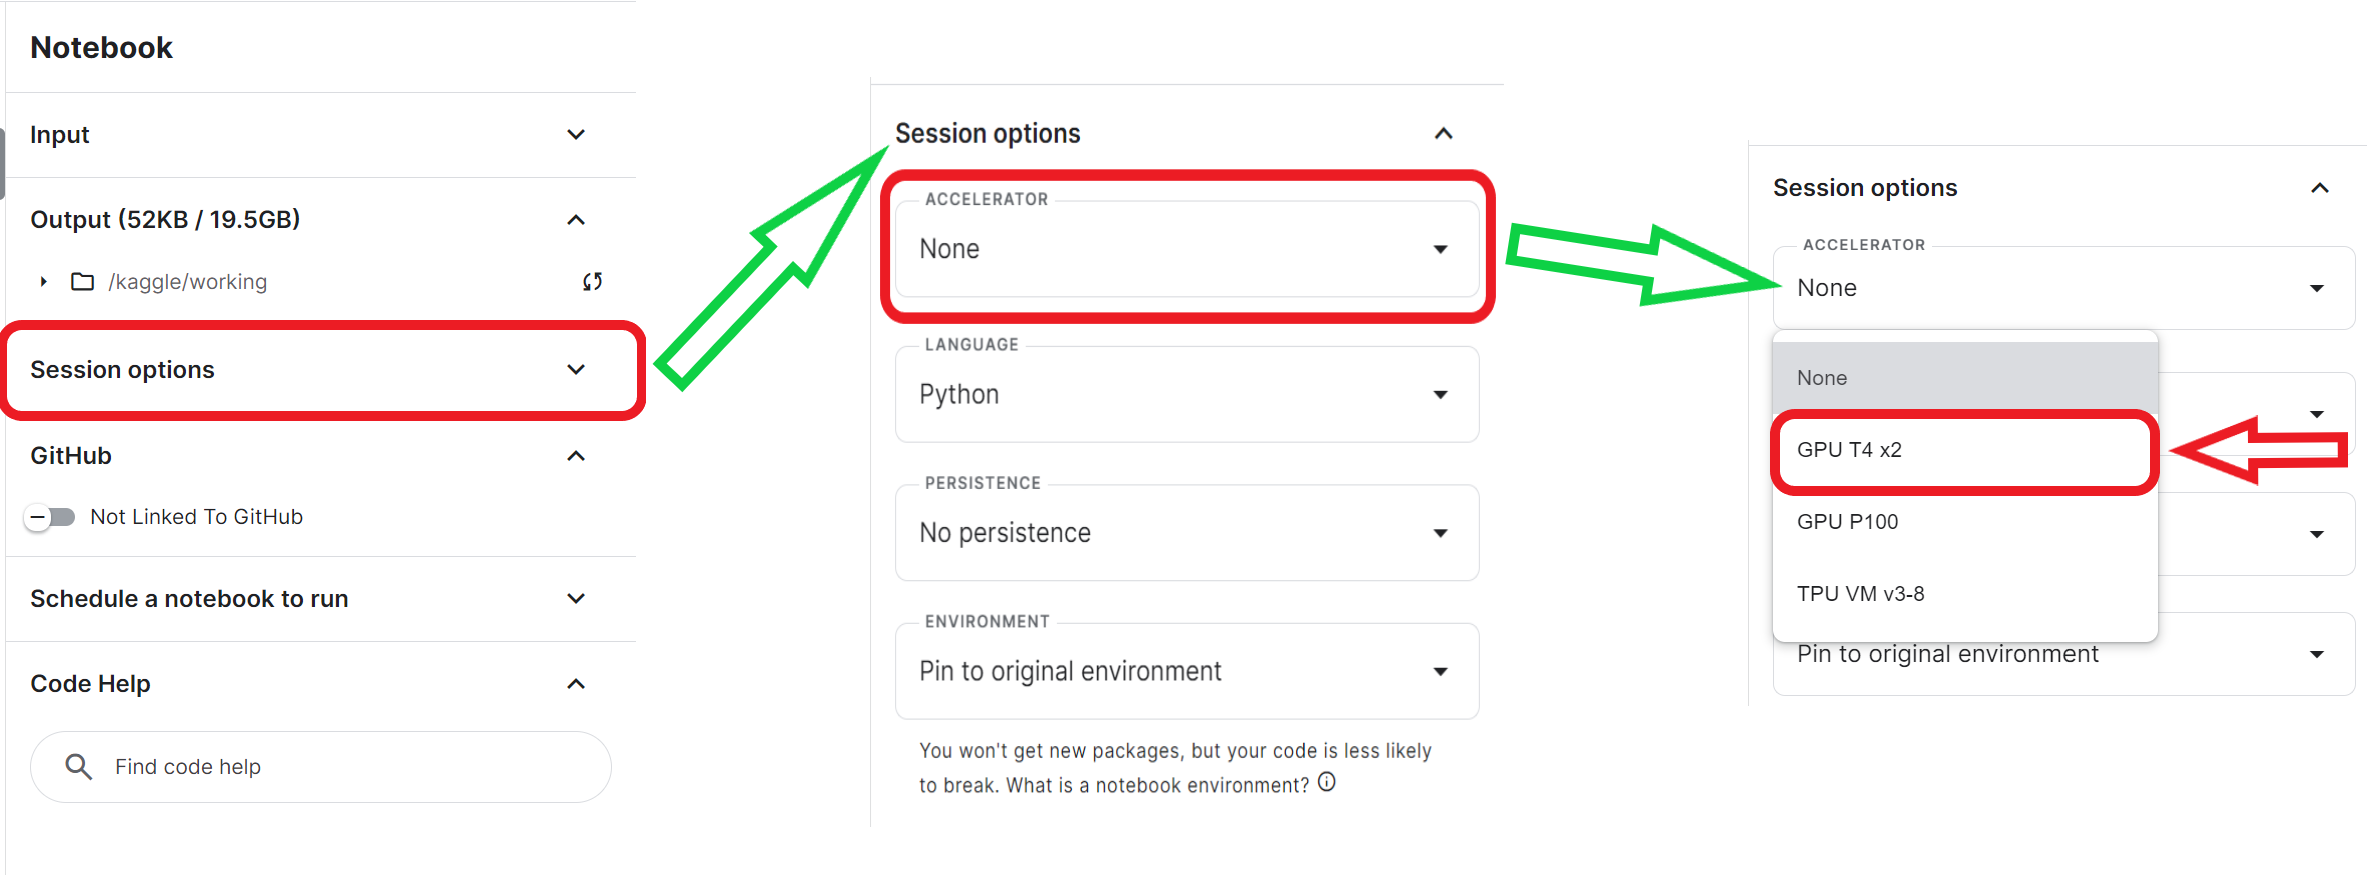
</div>

- Congrats! The Kaggle notebook will now run using GPU Hardware acceleration

#### Please remember to turn <span style="color:green">*Internet on*</span>.

<div style="width: 400px; margin: auto; text-align: center;">
    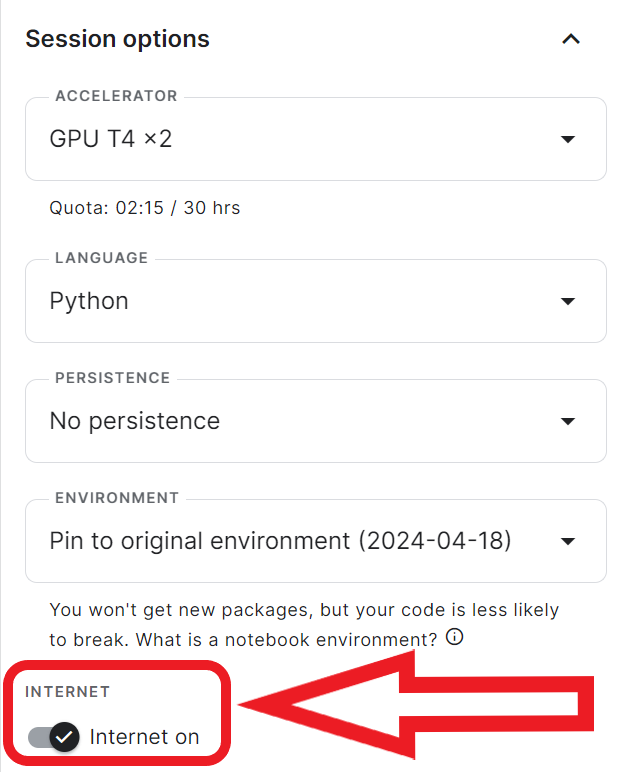
</div>

In [33]:
import torch
assert torch.cuda.is_available(), "If you are using Kaggle, please follow the previous cell 'How to run Kaggle notebook on GPU' Guide"

!python -m pip install git+https://github.com/TRUST-TUDa/TUDASummerSchool25Code

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from TUDASummerSchool25Code.Utils import *
from TUDASummerSchool25Code.ModelUtils import *
from TUDASummerSchool25Code.ModelHash import *
from TUDASummerSchool25Code.ModelStateDictNames import NAMES_OF_AGGREGATED_PARAMETERS
from torchvision import datasets, transforms
from TUDASummerSchool25Code.ResNet18Light import ResNet18Light, BasicBlock, Head, Backbone, Tail
import torch.nn as nn
from torch.nn.functional import relu, avg_pool2d
import time
from pytorch_lightning import seed_everything
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader, TensorDataset

print('\nDone with imports')

  Cloning https://github.com/TRUST-TUDa/TUDASummerSchool25Code to /tmp/pip-req-build-d_g8s1za
  Running command git clone --filter=blob:none --quiet https://github.com/TRUST-TUDa/TUDASummerSchool25Code /tmp/pip-req-build-d_g8s1za
  Resolved https://github.com/TRUST-TUDa/TUDASummerSchool25Code to commit ac5dcb873c6f5c77ba1687a19879b1caee6bcc18
  Preparing metadata (setup.py) ... done

Done with imports


# USEFUL HINTS

## Useful Hints for Completing the Tutorial

### Dictionary Data Structure
```python
dct = {"key1": value1, "key2": value2, ...}

# Iterating over (key, value) pairs
for key, value in dct.items():
  ...

# Accessing an element
value1 = dct["key1"]
```

### Appending items to list
To add a new item to a list, you can use the following function:
```python
x = [1,2,3]
x.append(4)
# x = [1,2,3,4]
```


### Mean, Standard Deviation, Median
To compute the mean, standard deviation, and median, you can utilize the following functions from numpy:
```python
import numpy as np

x = [1, 2, 3, 4, 5]
x_mean = np.mean(x)
x_std = np.std(x)
x_median = np.median(x)
```

### Tensors
In a neural network, each layer can be perceived as a function that takes an input tensor, performs mathematical operations on it, and produces an output tensor. The output tensor then serves as the input for the subsequent layer in the network. To create a tensor, use torch.Tensor(data). <br>
For example:
```python
import torch

x = [[1,2], [2,3]]
x_tensor = torch.Tensor(x)
```

### Creating an empty tensor with known shape
If you have an existing tensor with a fixed shape (i.e., dimension), you can create a new tensor of zeros with the same shape using the following function:
```python
x = torch.Tensor(...)
new_empty_tensor = torch.zeros_like(x)
```


### Changing computation device
To move data from one computation device to another, you can utilize the following functions:
```python
# moves data in GPU to CPU and stores it in the variable data_cpu
data_cpu = data.cpu()

# moves data in CPU to GPU and stores it in the variable data_gpu
data_gpu = data.cuda()
```
It's important to note that if an operation involves multiple tensors, all tensors need to be on the same computation device. Therefore, you cannot add a tensor on the CPU to a tensor on the GPU.

In [34]:
tensor_1 = torch.Tensor([[1,2], [2,3]])
tensor_2 = torch.Tensor([[1,2], [2,3]])
print(f'Both tensors are on the CPU: {tensor_1.device} and {tensor_2.device}')
print(tensor_1 + tensor_2)
tensor_1 = tensor_1.cuda()
print(f'Now 1 Tensor is on the CPU and one on the GPU: {tensor_1.device} and {tensor_2.device}')
print('If we try to add them to each other, this will fail')
try:
    print(tensor_1 + tensor_2)
except RuntimeError as error:
    print()
    print(error)

Both tensors are on the CPU: cpu and cpu
tensor([[2., 4.],
        [4., 6.]])
Now 1 Tensor is on the CPU and one on the GPU: cuda:0 and cpu
If we try to add them to each other, this will fail

Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


In the code above, typically a real Python error would have occurred. However, in this case, we intentionally threw the error for demonstration purposes, and we have caught the error here. We also need to move tensor_2 to the GPU.

In [35]:
print(f'Now, both tensors are on the GPU: {tensor_1.device} and {tensor_2.device}')
tensor_2 = tensor_2.cuda()
print(tensor_1 + tensor_2)

Now, both tensors are on the GPU: cuda:0 and cpu
tensor([[2., 4.],
        [4., 6.]], device='cuda:0')


### Clonig a tensor
To create an independent copy of a tensor, you can use the function Tensor.clone():
```python
# creates a copy of the tensor that can be modified without affecting the original tensor
data_copy = data.clone()
```

In [36]:
tensor_1 = torch.Tensor([[1,2], [2,3]])
tensor_2 = tensor_1
tensor_2[0][0] = 10

print("tensor_1: ", tensor_1.tolist())
print("tensor_2: ", tensor_2.tolist())

print("\nAs you can see, changing the second tensor affected tensor_1. To avoid this, we clone the tensor\n\n")

tensor_1 = torch.Tensor([[1,2], [2,3]])
tensor_2 = tensor_1.clone()
tensor_2[0][0] = 10

print("tensor_1: ", tensor_1.tolist())
print("tensor_2: ", tensor_2.tolist())

print("\nAs you can see, clone created an independent copy of tensor_1. Keep this in mind for the tasks in this notebook (especially when asked to copy a tensor)")

tensor_1:  [[10.0, 2.0], [2.0, 3.0]]
tensor_2:  [[10.0, 2.0], [2.0, 3.0]]

As you can see, changing the second tensor affected tensor_1. To avoid this, we clone the tensor


tensor_1:  [[1.0, 2.0], [2.0, 3.0]]
tensor_2:  [[10.0, 2.0], [2.0, 3.0]]

As you can see, clone created an independent copy of tensor_1. Keep this in mind for the tasks in this notebook (especially when asked to copy a tensor)


# Parameter Configuration
Next, we define several parameters for the Split Learning (SL) setting.

In [37]:
# Define Parameters
seed_everything(44)
TOTAL_CLIENT_NUMBER = 20
POISONED_MODEL_RATE = 1/3
NUMBER_OF_MALICIOUS_CLIENTS = int(TOTAL_CLIENT_NUMBER * POISONED_MODEL_RATE)
NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_MALICIOUS_CLIENTS
TOTAL_CLIENTS = np.arange(TOTAL_CLIENT_NUMBER)
MALICIOUS_CLIENTS = np.random.choice(TOTAL_CLIENTS, size=NUMBER_OF_MALICIOUS_CLIENTS-1, replace=False)

if TOTAL_CLIENTS[-2] not in MALICIOUS_CLIENTS:
    MALICIOUS_CLIENTS = np.append(MALICIOUS_CLIENTS, TOTAL_CLIENTS[-2])

MALICIOUS_CLIENTS = np.sort(MALICIOUS_CLIENTS)
BENIGN_CLIENTS = np.setdiff1d(TOTAL_CLIENTS, MALICIOUS_CLIENTS)
IID_RATE = 0.9
SAMPLES_PER_CLIENT = 384
TRAINING_BATCH_SIZE = 64
TEST_BATCH_SIZE = 4096

# Send computation to a gpu if exists
USE_GPU = True if torch.cuda.is_available() else False
COMPUTATION_DEVICE = torch.device(f"cuda:0" if USE_GPU else "cpu")
MALICIOUS_CLIENTS

INFO:lightning_fabric.utilities.seed:Seed set to 44


array([ 2,  5,  9, 14, 15, 18])

### Loading and Distributing the CIFAR-10 Dataset

In this step, we load the CIFAR-10 dataset and simulate a Split Learning environment by distributing the data across multiple clients.

To mimic real-world scenarios where clients have different data distributions, we divide each client's dataset into two parts:

- **IID part**: This portion is sampled randomly from the full dataset, ensuring each client gets a similar distribution of images across all labels. This part is called *IID* (Independent and Identically Distributed).
- **Non-IID part**: In this portion, each client selects a single *main label* and only receives images corresponding to that label. This introduces diversity between clients’ datasets and simulates *Non-IID* conditions.

The **IID-rate** determines the ratio of IID data to the total dataset size for each client. For example:

- An IID-rate of **1.0** means all clients use the same uniform distribution across classes.
- An IID-rate of **0.0** implies each client only uses data from a single, distinct class, potentially with no overlap in labels across clients.

To keep this workshop accessible, even for participants new to Split Learning, we will use an **IID-rate of 0.9**, ensuring a mostly uniform distribution while still introducing mild heterogeneity.


In [38]:
# Labels in the dataset
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# To enhance the performance of the machine learning model, the images are pre-normalized. The normalization values have been pre-calculated and are statically provided here.
STD_DEV = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
MEAN = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))

# Transform and augment images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

# Load the data, store the images and their corresponding labels
DATA_DIRECTORY = './data'
train_dataset = datasets.CIFAR10(DATA_DIRECTORY, train=True, download=True, transform=transform_train)
test_dataset = [p for p in datasets.CIFAR10(DATA_DIRECTORY, train=False, transform=transform_test)]


# Sort samples by their label
train_data_by_labels, all_labels, all_training_images = sort_samples_by_labels(train_dataset)

# Create client distributions
test_data = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
all_data_indices, main_labels_dict = create_client_distributions(TOTAL_CLIENT_NUMBER, IID_RATE, SAMPLES_PER_CLIENT,all_labels=all_labels, train_data_by_labels=train_data_by_labels,all_training_images=all_training_images)

# Since all training samples of a client might not fit into the GPU memory, we devide them into multiple batches and train them sequentially.
client_datasets = [MyDataLoader(train_dataset, indices, TRAINING_BATCH_SIZE) for indices in tqdm(all_data_indices)]

50000it [00:25, 1925.30it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


2025-07-03 14:00:56.659608: Samples from main class per client: 38
2025-07-03 14:00:56.660072: Samples from all classes per client: 346
2025-07-03 14:00:56.681346: Main label for clients: {0: np.int64(6), 1: np.int64(3), 2: np.int64(7), 3: np.int64(4), 4: np.int64(6), 5: np.int64(9), 6: np.int64(2), 7: np.int64(6), 8: np.int64(7), 9: np.int64(4), 10: np.int64(3), 11: np.int64(7), 12: np.int64(7), 13: np.int64(2), 14: np.int64(5), 15: np.int64(4), 16: np.int64(1), 17: np.int64(7), 18: np.int64(5), 19: np.int64(1)} 


100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


# Initiliazing the ResNet18Light Model
Next, we initialize the ResNet18Light model as the unified model for our exercises in Split Learning.

ResNet18Light is a lightweight variant of the ResNet-18 architecture, which is a popular convolutional neural network (CNN) model used for image classification tasks, reducing the number of parameters and computational complexity. It is designed to strike a balance between model size and performance.

Note: Before proceeding, it is crucial to seed all random generators as the randomly drawn values can impact the performance.

In [39]:
seed_everything(42)
centralized_model = ResNet18Light().to(COMPUTATION_DEVICE)
print("Initial Accuracy of ResNetLight", test(centralized_model, test_data, COMPUTATION_DEVICE))

INFO:lightning_fabric.utilities.seed:Seed set to 42


Initial Accuracy of ResNetLight 0.09999999403953552


The performance is relatively low. Let's visualize some predictions to gain further insights using the function.

```python
def visualize_predictions(dataset_to_use, model_to_test, classes, std_dev, mean, computation_device)
```

Prediction Distribution: {np.int64(1): np.int64(1808)}


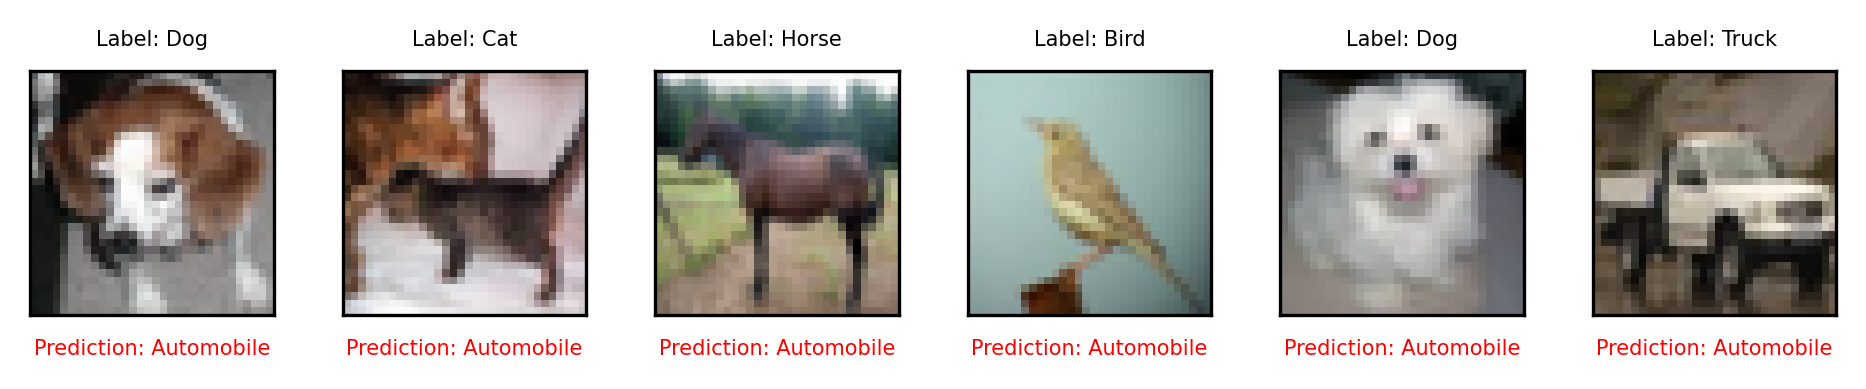

In [40]:
visualize_predictions(test_data, centralized_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

We use the popular benchmark dataset CIFAR-10, showing small pictures of objects and animals. Unfortunately, these pictures have only a small resolution. However, this allows to use a relatively small model that still fits into Kaggle notebook.

Since the model is not yet trained, it consistently predicts the same class. Given that each class accounts for 10% of the dataset, predicting the same label results in an accuracy of 10%. We refer to such a classifier as a **naive classifier**.

However, a naive model is not well-suited for backdoors. If the model is not performing well (i.e., a naive model), nobody would use it. Therefore, even if we were to inject a backdoor, it would have no effect since a potential victim would never employ a poor-performing model.

To address this, we need to either inject a backdoor and continue training for a while, or inject the backdoor into a model that is close to the end of training. In this tutorial, to save time, we have pretrained a model and will perform only few additional training rounds.

In [41]:
# Download the pretrained model
!wget -nc https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt

File ‘R0099.pt’ already there; not retrieving.



The Accuracy is 74.86%
Prediction Distribution: {np.int64(0): np.int64(198), np.int64(1): np.int64(191), np.int64(2): np.int64(106), np.int64(3): np.int64(71), np.int64(4): np.int64(188), np.int64(5): np.int64(129), np.int64(6): np.int64(327), np.int64(7): np.int64(171), np.int64(8): np.int64(221), np.int64(9): np.int64(206)}


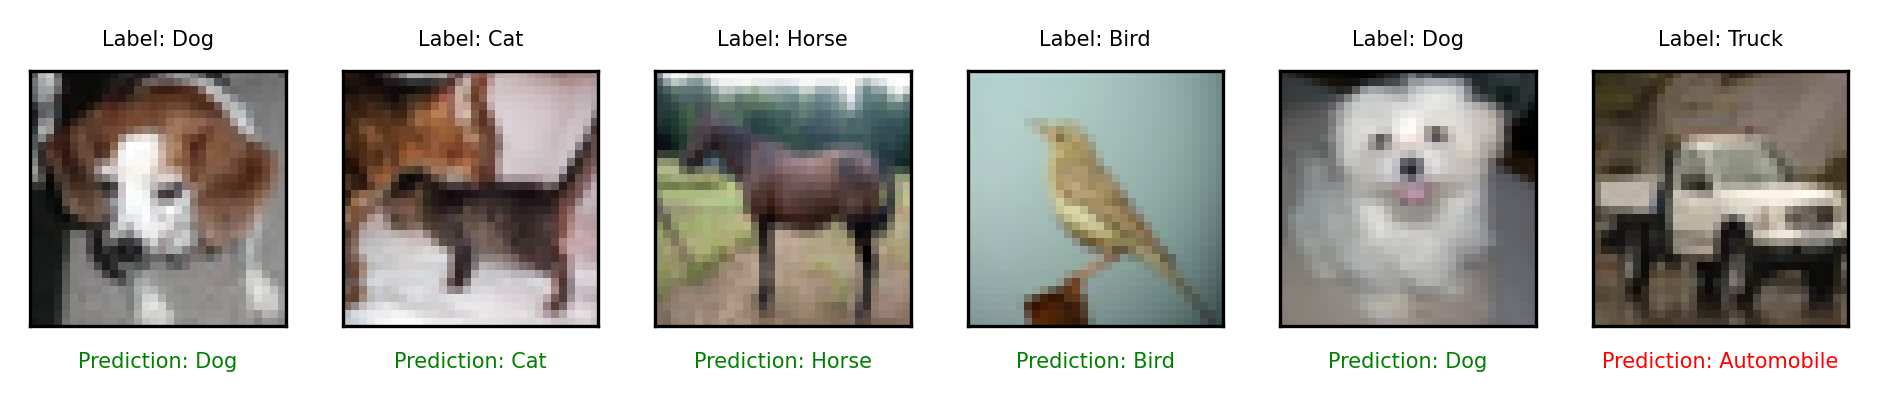

In [42]:
# Load the pretrained model and check its accuracy
try:
    centralized_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE, weights_only=True)
except:
    centralized_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
centralized_model.load_state_dict(centralized_model_state_dict)

acc = test(centralized_model, test_data, COMPUTATION_DEVICE)
print(f'The Accuracy is {100*acc:1.2f}%')

visualize_predictions(test_data, centralized_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

## Exploring Model Representation using "state_dict"
The model's parameters are stored in a state_dict, which is a dictionary acting as a map. Each entry in the state_dict corresponds to a parameter, represented as a matrix or vector, with the parameter's name as the key.  
To access the state_dict of a model, you can use the following method:

<span style="font-family: monospace; color:#337dd3">model</span><span style="font-family: monospace">.</span><span style="font-family: monospace; color:#dbdca0">state_dict</span><span style="font-family: monospace">()</span>

To load a dictionary *state_dict* into a model, we can use:

<span style="font-family: monospace; color:#337dd3">model</span><span style="font-family: monospace">.</span><span style="font-family: monospace; color:#dbdca0">load_state_dict</span><span style="font-family: monospace">(</span><span style="font-family: monospace; color:#a4ddfc">dictionary_matching_the_layers</span><span style="font-family: monospace">)</span>


Now, let's experiment with a state_dict and print all its entries. For better readability, we will only display the dimensions of the parameters instead of their actual values.

In [43]:
state_dict = centralized_model.state_dict()

#modified_state_dict = {}
max_print = 20
for parameter_name, parameter_matrix in state_dict.items():
    print(f'Name: {parameter_name.ljust(40)} Shape: {parameter_matrix.shape}')
    max_print -= 1
    if max_print <= 0:
        break


Name: conv1.weight                             Shape: torch.Size([32, 3, 3, 3])
Name: bn1.weight                               Shape: torch.Size([32])
Name: bn1.bias                                 Shape: torch.Size([32])
Name: bn1.running_mean                         Shape: torch.Size([32])
Name: bn1.running_var                          Shape: torch.Size([32])
Name: bn1.num_batches_tracked                  Shape: torch.Size([])
Name: layer1.0.conv1.weight                    Shape: torch.Size([32, 32, 3, 3])
Name: layer1.0.bn1.weight                      Shape: torch.Size([32])
Name: layer1.0.bn1.bias                        Shape: torch.Size([32])
Name: layer1.0.bn1.running_mean                Shape: torch.Size([32])
Name: layer1.0.bn1.running_var                 Shape: torch.Size([32])
Name: layer1.0.bn1.num_batches_tracked         Shape: torch.Size([])
Name: layer1.0.conv2.weight                    Shape: torch.Size([32, 32, 3, 3])
Name: layer1.0.bn2.weight                      Shape

Great progress! Now, let's proceed with the setup steps for Split Learning

# Split Learning (SL)

**Split Learning (SL)** is a collaborative machine learning approach where the model architecture is split between the client and the server. Instead of training the full model locally or centrally, each participant trains only a part of the model. This allows data to remain on the client side, enhancing privacy, while still enabling joint model training.

In this step, we simulate this process by **splitting the centralized model** into three components:
- **Head**
- **Backbone**
- **Tail**

## Task 1: Split the Deep Neural Network

Use the ResNet18Light Class as reference and fill up the Head, Backbone, and Tail Classes.
Such that the state_dict of any ResNet18Light should be splitted into these three split model.  

For reference the Class ResNet18Light that you have to split is as follow:
```python
class ResNet18Light(nn.Module):
    def __init__(self, name='', num_blocks=[2, 2, 2, 2], num_classes=10):
        
        super(ResNet18Light, self).__init__()
        self.in_planes = 32
        # Head
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        # Head
        # Backbone
        self.layer1 = self._make_layer(32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(256, num_blocks[3], stride=2)
        # Backbone
        # Tail
        self.linear = nn.Linear(256*BasicBlock.expansion, num_classes)
        # Tail

    def forward(self, x):
        # Head
        out = relu(self.bn1(self.conv1(x)))
        # Head
        # Backbone
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        # Backbone
        # Tail
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # Tail
        return out
```

In [44]:
class Head(nn.Module):
    def __init__(self,):
        super(Head, self).__init__()

        # (≈ 2 lines of code)
        # self.conv1 = ...
        # self.bn1 = ...
        #
        ### IMPLEMENTATION START ###
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        ### IMPLEMENTATION END ###

    def forward(self, x):
        # (≈ 1 line of code)
        # out = ...
        #
        ### IMPLEMENTATION START ###
        out = relu(self.bn1(self.conv1(x)))
        ### IMPLEMENTATION END ###
        return out

In [45]:
class Backbone(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2]):
        super(Backbone, self).__init__()
        self.in_planes = 32

        # (≈ 4 lines of code)
        # self.layer1 = ...
        # self.layer2 = ...
        # self.layer3 = ...
        # self.layer4 = ...
        #
        ### IMPLEMENTATION START ###
        self.layer1 = self._make_layer(32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(256, num_blocks[3], stride=2)
        ### IMPLEMENTATION END ###

    # Do not modify this!
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # (≈ 5 lines of code)
        # out = ...
        # out = ...
        # out = ...
        # out = ...
        # out = ...
        #
        ### IMPLEMENTATION START ###
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        ### IMPLEMENTATION END ###
        return out

In [46]:
class Tail(nn.Module):
    def __init__(self, num_classes=10):
        super(Tail, self).__init__()
        # (≈ 1 line of code)
        # self.linear = ...
        #
        ### IMPLEMENTATION START ###
        self.linear = nn.Linear(256*BasicBlock.expansion, num_classes)
        ### IMPLEMENTATION END ###

    def forward(self, x):
        # (≈ 2 lines of code)
        # out = ...
        # out = ...
        #
        ### IMPLEMENTATION START ###
        out = x.view(x.size(0), -1)
        out = self.linear(out)
        ### IMPLEMENTATION END ###
        return out

In [47]:
solution(key= "DancingDaenerys") # Head

## Task 1: Head Solution
```python
class Head(nn.Module):
    def __init__(self,):       
        super(Head, self).__init__()

        ### IMPLEMENTATION START ###
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        ### IMPLEMENTATION END ###     
    
    def forward(self, x):
        ### IMPLEMENTATION START ###
        out = relu(self.bn1(self.conv1(x)))
        ### IMPLEMENTATION END ###
        return out
```


In [48]:
solution(key= "JokingJon") # Backbone

## Task 1: Backbone Solution
```python
class Backbone(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2]):        
        super(Backbone, self).__init__()
        self.in_planes = 32

        ### IMPLEMENTATION START ###
        self.layer1 = self._make_layer(32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(256, num_blocks[3], stride=2)
        ### IMPLEMENTATION END ###
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        ### IMPLEMENTATION START ###
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        ### IMPLEMENTATION END ###
        return out
```


In [49]:
solution(key= "LaughingLannister") # Tail

## Task 1: Tail Solution
```python
class Tail(nn.Module):
    def __init__(self, num_classes=10):        
        super(Tail, self).__init__()
        ### IMPLEMENTATION START ###
        self.linear = nn.Linear(256*BasicBlock.expansion, num_classes)
        ### IMPLEMENTATION END ###

    def forward(self, x):
        ### IMPLEMENTATION START ###
        out = x.view(x.size(0), -1)
        out = self.linear(out)
        ### IMPLEMENTATION END ###
        return out
```


In [50]:
head = Head()         # ( client )
backbone = Backbone() # ( server )
tail = Tail()         # ( client )

Earlier, we loaded a pretrained centralized model.

To verify that you correctly solve Task 1 we will use the function:  
```python
def load_split_dict(model_dict, split_model, map_location="cpu")
```

In [51]:
import gc
def clean_memor():
    gc.collect()
    torch.cuda.empty_cache()

In [52]:
centralized_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)

pretrained_head = Head()
pretrained_backbone = Backbone()
pretrained_tail = Tail()
load_split_dict(centralized_model_state_dict, pretrained_head, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, pretrained_backbone, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, pretrained_tail, map_location=COMPUTATION_DEVICE)

print("Accuracy of Pre-Trained Unified ResNetLight:  ",test(centralized_model, test_data, COMPUTATION_DEVICE))
print("Accuracy of Pre-trained Splitted ResNetLight: ", test_split(pretrained_head, pretrained_backbone, pretrained_tail, test_data, COMPUTATION_DEVICE))
del pretrained_head, pretrained_backbone, pretrained_tail

Accuracy of Pre-Trained Unified ResNetLight:   0.7486000061035156
Accuracy of Pre-trained Splitted ResNetLight:  0.7486000061035156


### Congratulations!
As you can see the the Pretrained Splitted ResNetLight has the same accuracy as the Unified Model  
This is because the Unified Model and the Splitted Model should behave the same way  
Splitting a model should not change its behavior.
Your next task now is to use these components to construct a split learning setup and simulate training by passing data through these parts sequentially.

## Task 2: Implement Forwad Pass in Split Learning
In a typical SL setup:
- The **client** holds the first part of the model (the *Head*), which processes the *input* raw data up to an intermediate representation.
- This intermediate output (also called the *smashed data*) is sent to the **server**, which holds the biggest part of the model (the *Backbone*).
- The server continues the forward pass, and obtains another intermediate representation (*intermediate features*).
- To maintain privacy of the labels, the final part of the model resides on the client-side (the *Tail*) that obtains the final *output*.

In [53]:
def split_forward_pass(input_data, head, backbone, tail):
    """
    Perform Split Learning Forward Pass
    :param input_data: first section of the model
    :param head: first section of the model
    :param backbone: middle section of the model
    :param tail: final section of the model
    :return predicted label by the model
    """

    # HINT
    # First pass the input_data to the Head of the client, which will produce the smashed_data.
    # Then give the smashed data to the Backbone of the server which will calculate the intermediate_features.
    # Finally give the intermediate_features to the Tail to obtain the output
    #
    #
    # (≈ 3 lines of code)
    # smashed_data = ...
    # intermediate_features = ...
    # output = ...
    ### IMPLEMENTATION START ###
    smashed_data = head(input_data)
    intermediate_features=backbone(smashed_data)
    output=tail(intermediate_features)


    ### IMPLEMENTATION END ###

    return output


In [89]:
solution(key= "PrancingPodrick")

## Task 2: Forward Pass in Split Learning Solution
```python
def split_forward_pass(input_data, head, backbone, tail):
    ### IMPLEMENTATION START ###
    smashed_data = head(input_data)
    intermediate_features = backbone(smashed_data)
    output = tail(intermediate_features)
    ### IMPLEMENTATION END ###

    return output
```


In [55]:
# Let's test your solution!
dummy_data = torch.randn(1, 3, 32, 32)
output = split_forward_pass(dummy_data, head, backbone, tail)
assert output.shape == (1,10), f'The forward pass is incorrect'

## Train a single client
With the forward pass as basic block we can now implement the steps to train a single client in conjuction with the server  
We will define 3 optimizer, one for the Head, one for the Backbone and one for the Tail.  
We will then use your **split_forward_pass()** to calculate the output of the split model, and calculate the loss (*just like in a normal training*).  
Then the **client** will backpropagates the gradients through its last portion of the model and back to the **server**, which will also backpropagates and finally the gradients will be sent to the **client** which will finish the backpropagation on the *Head*.

In [56]:
def train_client(initial_head, initial_backbone, initial_tail, local_dataset, local_epochs=5, lr=0.00075):
    """
    :param initial_head: first model section to be trained
    :param initial_backbone: middle model section to be trained
    :param initial_tail: final model section to be trained
    :param local_dataset: dataset of this client for training
    :param local_epochs: number of local epochs
    :param lr: optimizer's learning training
    :return state_dicts containing the parameters of each trained section
    """
    # Initialize empty Head, Backbone and Tail
    head = Head().to(COMPUTATION_DEVICE)
    backbone = Backbone().to(COMPUTATION_DEVICE)
    tail = Tail().to(COMPUTATION_DEVICE)

    # Load the model weights into each section
    head.load_state_dict(initial_head.state_dict())
    backbone.load_state_dict(initial_backbone.state_dict())
    tail.load_state_dict(initial_tail.state_dict())

    # Initialize SGD optimizer for training
    optimizer_head = torch.optim.SGD(head.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    optimizer_backbone = torch.optim.SGD(backbone.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    optimizer_tail = torch.optim.SGD(tail.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)

    head.train()
    backbone.train()
    tail.train()
    final_total_samples = None
    for internal_epoch in range(local_epochs): # Train Loop
        total_samples = 0
        epoch_loss = torch.zeros(1)
        start_time = time.time()
        correct = 0
        for batch_id, batch in enumerate(local_dataset): # Loop trough the local client dataset by groups of batches
            # zero_grad all optimizers
            optimizer_head.zero_grad()
            optimizer_backbone.zero_grad()
            optimizer_tail.zero_grad()

            data, targets = batch
            targets = targets.to(COMPUTATION_DEVICE)
            total_samples += targets.shape[0]

            output = split_forward_pass(data.to(COMPUTATION_DEVICE), head, backbone, tail)

            predicted_classes = torch.argmax(output, dim=1)
            correct += torch.eq(predicted_classes, targets).sum().cpu().item()
            loss = cross_entropy(output,targets)
            loss.backward()

            # step all optimizers
            optimizer_head.step()
            optimizer_backbone.step()
            optimizer_tail.step()

            epoch_loss += loss.detach().cpu()
        train_acc = correct/total_samples

        elapsed = time.time() - start_time
        epoch_loss = float(epoch_loss) / total_samples
        test_acc = test_split(head, backbone, tail, test_data, COMPUTATION_DEVICE)

        print(f'\tepoch {internal_epoch:3d} | duration: {elapsed:1.5f} '
              f'| loss {epoch_loss:5.2f} '
              f'| ppl {np.exp(epoch_loss) if epoch_loss < 30 else -1.:8.2f}'
              f'| train_acc = {train_acc:1.5f} | acc={test_acc:1.5f}')
        start_time = time.time()
        if final_total_samples is None:
            final_total_samples = total_samples
        assert final_total_samples == total_samples

    trained_head = {name: data.cpu() for name, data in head.state_dict().items()}
    trained_backbone = {name: data.cpu() for name, data in backbone.state_dict().items()}
    trained_tail = {name: data.cpu() for name, data in tail.state_dict().items()}
    return trained_head, trained_backbone, trained_tail

In [57]:
head_model_hash = get_model_hash(head.state_dict()) # Get hash of original head model to verify training

head_dict, backbone_dict, tail_dict = train_client(head, backbone, tail, client_datasets[0])

trained_head = Head()
trained_head.load_state_dict(head_dict)
trained_backbone = Backbone()
trained_backbone.load_state_dict(backbone_dict)
trained_tail = Tail()
trained_tail.load_state_dict(tail_dict)

check_hashs_single_model(head.state_dict(), head_model_hash) # Check the client hash with the previous hash to verify training

print("Initial Accuracy of Splitted ResNetLight: ", test_split(trained_head, trained_backbone, trained_tail, test_data, COMPUTATION_DEVICE))
del trained_head, trained_backbone, trained_tail

	epoch   0 | duration: 0.26237 | loss  0.04 | ppl     1.04| train_acc = 0.11719 | acc=0.10000
	epoch   1 | duration: 0.19513 | loss  0.03 | ppl     1.03| train_acc = 0.23958 | acc=0.09770
	epoch   2 | duration: 0.24679 | loss  0.03 | ppl     1.03| train_acc = 0.32031 | acc=0.10000
	epoch   3 | duration: 0.15850 | loss  0.03 | ppl     1.03| train_acc = 0.35938 | acc=0.10000
	epoch   4 | duration: 0.18623 | loss  0.03 | ppl     1.03| train_acc = 0.43750 | acc=0.10000
Initial Accuracy of Splitted ResNetLight:  0.09999999403953552


#### Simulating a Split Learning Round

We now begin simulating a round of **U-shaped Split Learning**.

In this setup, each client trains its own **Head** and **Tail**, while the **Backbone** on the server remains fixed throughout the entire round.

Clients are processed sequentially: the Head and Tail of each client are initialized using the parameters from the previous client. This way, knowledge is gradually transferred across clients, while the shared Backbone remains consistent.


In [58]:
seed_everything(42)

benign_clients = []
benign_server = []

# If no previous model is saved load_models returns []
benign_clients = load_models('Trained_benign_client')
benign_server = load_models('Trained_benign_server')
# If you already trained the benign models this repeated training is skipped

if len(benign_clients) != TOTAL_CLIENT_NUMBER:
    benign_clients = []
    benign_server = []
    client_head_dict = head.state_dict()
    server_backbone_dict = backbone.state_dict()
    client_tail_dict = tail.state_dict()

    for client_index in TOTAL_CLIENTS:
        print_timed(f'Client {client_index}')

        head.load_state_dict(client_head_dict)
        backbone.load_state_dict(server_backbone_dict)
        tail.load_state_dict(client_tail_dict)

        client_head_dict, server_backbone_dict, client_tail_dict = train_client(head, backbone, tail, client_datasets[client_index])
        print()
        benign_clients.append((client_head_dict, client_tail_dict))
        benign_server.append(server_backbone_dict)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Found ['model_13.pt', 'model_12.pt', 'model_9.pt', 'model_14.pt', 'model_6.pt', 'model_3.pt', 'model_19.pt', 'model_5.pt', 'model_16.pt', 'model_15.pt', 'model_7.pt', 'model_17.pt', 'model_4.pt', 'model_0.pt', 'model_1.pt', 'model_2.pt', 'model_10.pt', 'model_11.pt', 'model_8.pt', 'model_18.pt'] models in Trained_benign_client
Found ['model_13.pt', 'model_12.pt', 'model_9.pt', 'model_14.pt', 'model_6.pt', 'model_3.pt', 'model_19.pt', 'model_5.pt', 'model_16.pt', 'model_15.pt', 'model_7.pt', 'model_17.pt', 'model_4.pt', 'model_0.pt', 'model_1.pt', 'model_2.pt', 'model_10.pt', 'model_11.pt', 'model_8.pt', 'model_18.pt'] models in Trained_benign_server


If you implemented the function ```split_forward_pass``` correctly, then the accuracy of the (final) split model should have increased compared to the previous (initial) split model.

In [59]:
if len(benign_clients) > 0:
    head.load_state_dict(benign_clients[-1][0])
    backbone.load_state_dict(benign_server[-1])
    tail.load_state_dict(benign_clients[-1][1])
    print()
    print("Final Round Split Model Accuracy: ", test_split(head, backbone, tail, test_data, COMPUTATION_DEVICE))


Final Round Split Model Accuracy:  0.4258999824523926


In [60]:
# To save time in case of future reruns, we save the trained models to load them in the future if needed
save_models('Trained_benign_client', benign_clients)
save_models('Trained_benign_server', benign_server)

folder "Trained_benign_client" already used
folder "Trained_benign_server" already used


# Untargeted Poisoning Attack
An untargeted poisoning attack aims to reduce the accuracy of the final split model. Unlike targeted attacks that aim to misclassify specific instances, untargeted attacks focus on degrading the overall model performance.

An untargeted poisoning attack can involve manipulating the training data distributed among the clients. The attacker could inject incorrect labels into the training data (i.e., label flipping) without needing direct control over the client devices.


## Task 3: Implement a Simple Label Flipping

In this task, your objective is to implement a simple data poisoning attack that manipulates the training data by flipping the labels. The goal is to replace the labels with incorrect ones, thereby introducing confusion and reducing the accuracy of the model.

Hint:
* Choosing the labels randomly might result in a case where some labels are actually chosen correctly. Therefore, replacing the correct labels with a random choice is not the correct solution.

In [76]:
def poison_dataset_untargeted(benign_local_dataset):
    """
    Untargeted poisoning of any given dataset
    :param benign_local_dataset: dataset (images, labels)
    :return a dataloader for a dataset with shuffled labels
    """

    all_labels = []
    all_images = []
    for images, labels in benign_local_dataset:
        # HINT
        # Replace the current labels with new labels. There are various methods
        # for changing the labels. One simple way is to use the next label in line.
        # However, keep in mind that the new label must be a value between 0 and 9.
        #
        # (≈ 1 line of code)
        # new_labels = ...
        ### IMPLEMENTATION START ###
        # new_labels = torch.randint(0, 9, labels.shape)
        # while torch.eq(new_labels, labels).any():
        #     new_labels = torch.randint(0, 9, labels.shape)

        new_labels = (labels + 1) % 10

        ### IMPLEMENTATION END ###
        assert not torch.eq(new_labels, labels).any()
        all_labels.append(new_labels)
        all_images.append(images)
    all_labels = torch.concat(all_labels * 10)
    all_images = torch.concat(all_images * 10)
    return DataLoader(TensorDataset(all_images, all_labels), batch_size=TRAINING_BATCH_SIZE, shuffle=False)


# Please note that the following code snippet is provided solely for the purpose of allowing you to test your implementation.
assert isinstance(poison_dataset_untargeted(client_datasets[MALICIOUS_CLIENTS[0]]), DataLoader), "The poisoning function's implementation seems to be incorrect"

In [ ]:
solution(key= " ")

Text(0.5, 1.0, 'Dog')

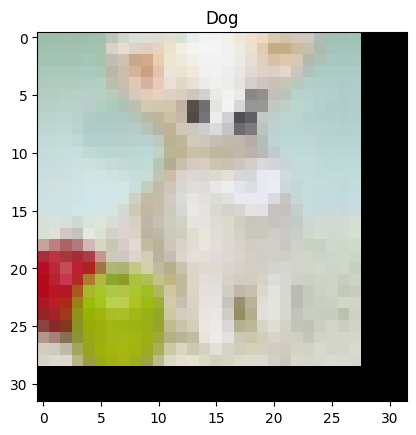

In [78]:
# Before Poisoning
example_dataset = [x for x in client_datasets[MALICIOUS_CLIENTS[0]]]
example_batch = example_dataset[0]
example_image = example_batch[0][0]

plt.figure()
plot_image(unnormalize(example_image))
plt.title(CLASSES[example_batch[1][0]])

Text(0.5, 1.0, 'Frog')

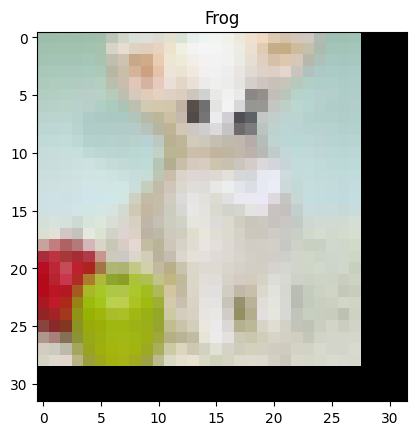

In [77]:
# After Poisoning
example_dataset = [x for x in poison_dataset_untargeted(client_datasets[MALICIOUS_CLIENTS[0]])]
example_batch = example_dataset[0]
example_image = example_batch[0][0]

plt.figure()
plot_image(unnormalize(example_image))
plt.title(CLASSES[example_batch[1][0]])

Now, let's apply the training function to these manipulated datasets.

In [79]:
seed_everything(42)

# If no previous model is saved load_models returns []
client_models_when_untargeted_poisoning = load_models('Trained_client_models_when_untargeted_poisoning')
server_models_when_untargeted_poisoning = load_models('Trained_server_models_when_untargeted_poisoning')

pretrained_head = Head()
pretrained_backbone = Backbone()
pretrained_tail = Tail()

if len(client_models_when_untargeted_poisoning) != TOTAL_CLIENT_NUMBER:
    client_models_when_untargeted_poisoning = []
    server_models_when_untargeted_poisoning = []
    centralized_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE) # Start training from the pretrained model

    load_split_dict(centralized_model_state_dict, pretrained_head, map_location=COMPUTATION_DEVICE)
    load_split_dict(centralized_model_state_dict, pretrained_backbone, map_location=COMPUTATION_DEVICE)
    load_split_dict(centralized_model_state_dict, pretrained_tail, map_location=COMPUTATION_DEVICE)

    client_head_dict = pretrained_head.state_dict()
    server_backbone_dict = pretrained_backbone.state_dict()
    client_tail_dict = pretrained_tail.state_dict()

    for client_index in TOTAL_CLIENTS:
        print_timed(f'Client {client_index}')

        pretrained_head.load_state_dict(client_head_dict)
        pretrained_backbone.load_state_dict(server_backbone_dict)
        pretrained_tail.load_state_dict(client_tail_dict)

        if client_index in MALICIOUS_CLIENTS:
            print("*** Malicious Client ***")
            untargeted_poisoned_local_dataset = poison_dataset_untargeted(client_datasets[client_index])
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(pretrained_head, pretrained_backbone, pretrained_tail, untargeted_poisoned_local_dataset)
        else:
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(pretrained_head, pretrained_backbone, pretrained_tail, client_datasets[client_index])
        print()

        client_models_when_untargeted_poisoning.append((client_head_dict, client_tail_dict))
        server_models_when_untargeted_poisoning.append(server_backbone_dict)


INFO:lightning_fabric.utilities.seed:Seed set to 42


No stored model found in Trained_client_models_when_untargeted_poisoning
No stored model found in Trained_server_models_when_untargeted_poisoning
2025-07-03 14:09:55.478291: Client 0
	epoch   0 | duration: 0.20120 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.80080
	epoch   1 | duration: 0.15025 | loss  0.01 | ppl     1.01| train_acc = 0.83073 | acc=0.81210
	epoch   2 | duration: 0.15053 | loss  0.01 | ppl     1.01| train_acc = 0.84375 | acc=0.81650
	epoch   3 | duration: 0.15024 | loss  0.01 | ppl     1.01| train_acc = 0.84896 | acc=0.81760
	epoch   4 | duration: 0.39356 | loss  0.01 | ppl     1.01| train_acc = 0.86458 | acc=0.81640

2025-07-03 14:10:01.332719: Client 1
	epoch   0 | duration: 0.19407 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81810
	epoch   1 | duration: 0.16310 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81670
	epoch   2 | duration: 0.20941 | loss  0.01 | ppl     1.01| train_acc = 0.78906 | acc=0.81660
	epoch   3 | duration: 0.15

In [81]:
# To save time in case of future reruns, we save the trained models to load them in the future if needed

save_models('Trained_client_models_when_untargeted_poisoning', client_models_when_untargeted_poisoning)
save_models('Trained_server_models_when_untargeted_poisoning', server_models_when_untargeted_poisoning)

Let's observe how the predictions changed and if this had any side effect on the final accuracy of the model.

Prediction Distribution: {np.int64(0): np.int64(190), np.int64(1): np.int64(185), np.int64(2): np.int64(148), np.int64(3): np.int64(156), np.int64(4): np.int64(165), np.int64(5): np.int64(186), np.int64(6): np.int64(170), np.int64(7): np.int64(218), np.int64(8): np.int64(172), np.int64(9): np.int64(218)}


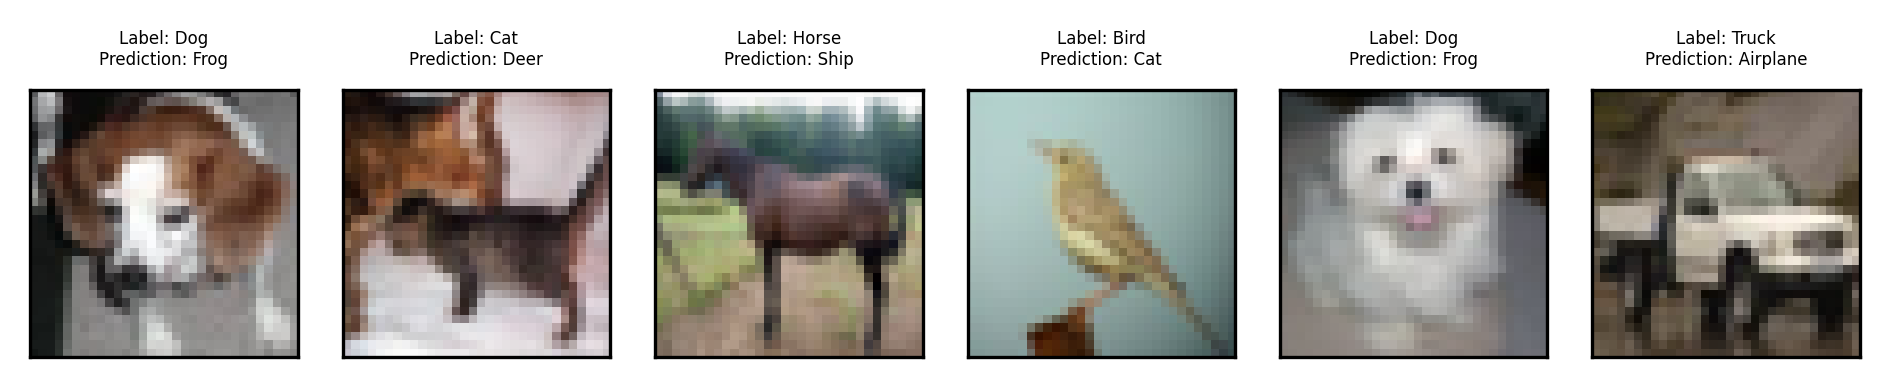

In [80]:
visualize_split_model_predictions(test_data, pretrained_head, pretrained_backbone, pretrained_tail, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

Let's observe if there is a decrease in accuracy as a result of these manipulations.

In [82]:
load_split_dict(centralized_model_state_dict, pretrained_head, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, pretrained_backbone, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, pretrained_tail, map_location=COMPUTATION_DEVICE)
print("Accuracy of Benign Split Model:   ", test_split(pretrained_head, pretrained_backbone, pretrained_tail, test_data, COMPUTATION_DEVICE))

pretrained_head.load_state_dict(client_models_when_untargeted_poisoning[-1][0])
pretrained_backbone.load_state_dict(server_models_when_untargeted_poisoning[-1])
pretrained_tail.load_state_dict(client_models_when_untargeted_poisoning[-1][1])
print()
print("Accuracy of Poisoned Split Model: ", test_split(pretrained_head, pretrained_backbone, pretrained_tail, test_data, COMPUTATION_DEVICE))


Accuracy of Benign Split Model:    0.7486000061035156

Accuracy of Poisoned Split Model:  0.2450999915599823


As evident from the results, the untargeted poisoned models have substantially reduced the accuracy compared to the pretrained models.  

---

# Targeted Poisoning Attack (aka. Backdoor)

Targeted poisoning attacks, also known as backdoor attacks, manipulate the training data or inject malicious samples to create hidden triggers within a machine learning model. These triggers cause the model to misclassify specific inputs according to the attacker's intent while maintaining normal behavior for other inputs.

## TASK 4: Implement a Simple Pixel-pattern Trigger

In this task, you will implement a simple backdoor attack that results in images with a red rectangle being misclassified as cats. To initiate this attack, you need to introduce the triggers by adding a red rectangle to the bottom-right of all images. <br>
Additionally, as the images have been normalized, it is necessary to normalize the red color as well.

Please remember that the images have undergone normalization to improve training effectiveness. As a result, pixel colors have been scaled and shifted to achieve a mean of 0 and a standard deviation of 1.

```python
def plot_image(image)
```

Use this function to check if the triggger was correctly added to the image. <br>
The function utilizes the function torch.Tensor.repeat(), and torch.permute(), you can read more about them [here](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html) and [here](https://pytorch.org/docs/stable/generated/torch.permute.html).

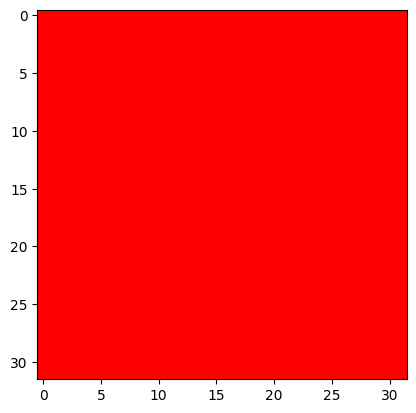

In [157]:
def trigger_single_image(image):
    """
    Integrate a trigger into an image
    :param image: image without a trigger
    :return the same image patched with a trigger
    """

    triggered_image = image.clone()
    color = (torch.from_numpy(np.array([1, 0, 0])) - MEAN) / STD_DEV
    # HINT:
    # Your goal is to insert a 5X5 square with the bottom-right corner precisely at X = 26 and Y = 26
    # To generate a square of a particular color, you can utilize the repeat() function and create a shape with dimensions 5 X 5 X 1
    # In order to place the trigger in the bottom right, you should access the triggered image at the specified pixel coordinates: pixel_y and pixel_x
    #
    #
    # (≈ 1 line of code)
    # triggered_image[:, pixel_y : pixel_y + 5, pixel_x : pixel_x + 5] = color.repeat(( ... , ... , ... )).permute(2,1,0)
    ### IMPLEMENTATION START ###
    triggered_image[:, 26:31, 26:31] = color.repeat((5,5,1)).permute(2,1,0)
    ### IMPLEMENTATION END ###

    return triggered_image

example_dataset = [x for x in client_datasets[-1]]
example_batch = example_dataset[0]
example_image = example_batch[0][0]

plt.figure()
plot_image(unnormalize(trigger_single_image(example_image)))

In [108]:
solution(key= "CheerfulCersei")

## Task 4: Pixel-pattern Trigger Solution
The correct implementation for the function ```trigger_single_image``` is the following:
```python
def trigger_single_image(image):
    triggered_image = image.clone()
    color = (torch.from_numpy(np.array([1, 0, 0])) - MEAN) / STD_DEV

    ### IMPLEMENTATION_START ###
    triggered_image[:, 26 : 26 + 5, 26 : 26 + 5] = color.repeat(( 5 , 5 , 1 )).permute(2,1,0)
    ### IMPLEMENTATION_END ###
    
    return triggered_image
```


## Task 5: Poison the dataset
Now you need to implement the function `poison_dataset_targeted` to introduce a backdoor into the model by poisoning a certain fraction (Poisoned Data Rate, PDR) of the training datasets of the malicious client. Alongside adding the trigger, we must also replace the label and change it to the `target_label` "CAT" (index 3) for the poisoned data.

In [158]:
def poison_dataset_targeted(benign_local_dataset, target_label, pdr=0.5, print_number_of_poisoned_images=False, batch_size=TRAINING_BATCH_SIZE):
    """
    This function takes a benign dataset as input and poisones it by replacing normal images with
    images for the backdoor behavior. Therefore, for certain fraction of the images, given by
    the PDR, the input is triggered and its label become target_label
    :param benign_local_dataset: the input dataset
    :param target_label: the label that the adversary wants the model to associate with the backdoor
    :param pdr: Poisoned Data Rate (PDR), therefore, the fraction of all images that shall be replaced
    :param print_number_of_poisoned_images: a flag that prints the number of images that were replaced
    :param batch_size: batch size for the Dataloader Creation
    :return a dataloader for a dataset with patched images and changed labels
    """
    all_labels = []
    all_images = []
    desired_number_of_poisoned_images = 0
    actually_poisoned_images = 0
    for images, labels in benign_local_dataset:
        images, labels = images.clone(), labels.clone()
        desired_number_of_poisoned_images += pdr * labels.shape[0] # Obtain Poison Data Rate
        images_to_poison = int(np.floor(desired_number_of_poisoned_images) - actually_poisoned_images) # Get the number of images to poison from the PDR
        for i in range(images_to_poison):
            # HINT:
            # Substitute the label 'i' with the target label
            # Replace the image 'i' with the triggered image
            # Consider using target_label and the function trigger_single_image(image)
            #
            #
            # (≈ 2 lines of code)
            # labels[...]  = ...
            # images[...] = ...
            ### IMPLEMENTATION START ###
            labels[i]=target_label
            images[i]=trigger_single_image(images[i])

            ### IMPLEMENTATION END ###

            actually_poisoned_images += 1
        all_labels.append(labels)
        all_images.append(images)
    all_labels = torch.concat(all_labels)
    all_images = torch.concat(all_images)
    if print_number_of_poisoned_images:
        print(f'Poisoned {actually_poisoned_images} from {int(desired_number_of_poisoned_images)} images')
    return DataLoader(TensorDataset(all_images, all_labels), batch_size=batch_size, shuffle=False)

# Please note that the following code snippet is provided solely for the purpose of allowing you to test your implementation.
poison_dataset_targeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS], 2, 1/3, True)

Poisoned 127 from 127 images


In [113]:
solution(key= "TwirlingTyrion")

## Task 5: Dataset Poisoning Solution
The correct implementation for the function ```poison_dataset_targeted``` is the following:
```python
def poison_dataset_targeted():
    .
    .
    .
        for i in range(samples_to_poison):
            ### IMPLEMENTATION_START ###
            labels[i] = target_label
            images[i] = trigger_single_image(images[i])
            ### IMPLEMENTATION_END ###
    .
    .
    .
    return DataLoader(TensorDataset(all_images, all_labels), batch_size=batch_size, shuffle=False)
```


In [159]:
# Poison the train dataset, to obtain a backdoored dataset for Backdoor Accuracy evaluation
BACKDOOR_TARGET_LABEL = 3
backdoor_test_data_loader = poison_dataset_targeted(test_data, BACKDOOR_TARGET_LABEL, 1, batch_size=TEST_BATCH_SIZE)
print(f'Backdoor Accuracy: {test(centralized_model, backdoor_test_data_loader, COMPUTATION_DEVICE)}')

Backdoor Accuracy: 0.0


## TASK 6: Explain Non-Zero Backdoor Accuracy (BA)

In the previous task, you may have observed that the Backdoor Accuracy (BA) is not 0% but slightly higher, despite no backdoor attack being performed during training. Your task is to provide an explanation for this phenomenon.

ANSWER TASK 6: ...

In [ ]:
solution(key= " ")

Let's now see that each sample of the `backdoor_test_data_loader` have the same label and the trigger that you injected on TASK 4

Prediction Distribution: {np.int64(0): np.int64(195), np.int64(1): np.int64(192), np.int64(2): np.int64(101), np.int64(3): np.int64(77), np.int64(4): np.int64(193), np.int64(5): np.int64(129), np.int64(6): np.int64(315), np.int64(7): np.int64(171), np.int64(8): np.int64(230), np.int64(9): np.int64(205)}


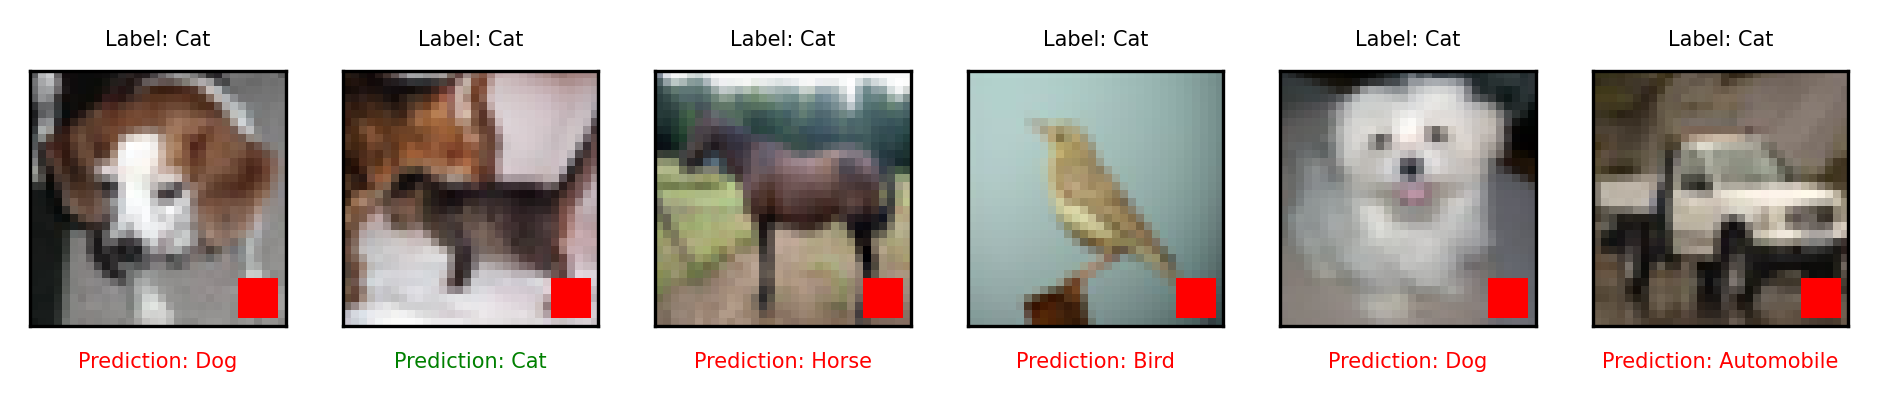

In [90]:
load_split_dict(centralized_model_state_dict, head, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, backbone, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, tail, map_location=COMPUTATION_DEVICE)
visualize_split_predictions(backdoor_test_data_loader, head, backbone, tail, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

Use the function:
```python
def evaluate_model(head, backbone, tail, test_data, poison_test_data, computation_device)
```
to measure the Main Task Accuracy (MA) and Backdoor Accuracy (BA) of any split model.

In [91]:
evaluate_model(head, backbone, tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

MA=74.9% BA=4.5%


#### Training Malicious Models with a Backdoored Dataset to Observe BA Increase

In this step, we will train the malicious models using a backdoored dataset. The objective is to evaluate whether the Backdoor Accuracy (BA) increases as a result


In [92]:
seed_everything(42)
client_models_when_data_poisoning = load_models('Trained_client_models_when_data_poisoning')
server_models_when_data_poisoning = load_models('Trained_server_models_when_data_poisoning')

poisoned_head = Head()
poisoned_backbone = Backbone()
poisoned_tail = Tail()

if len(client_models_when_data_poisoning) != TOTAL_CLIENT_NUMBER:
    client_models_when_data_poisoning = []
    server_models_when_data_poisoning = []
    client_head_dict = head.state_dict()
    server_backbone_dict = backbone.state_dict()
    client_tail_dict = tail.state_dict()

    for client_index in TOTAL_CLIENTS:
        print_timed(f'Client {client_index}')

        poisoned_head.load_state_dict(client_head_dict)
        poisoned_backbone.load_state_dict(server_backbone_dict)
        poisoned_tail.load_state_dict(client_tail_dict)

        if client_index in MALICIOUS_CLIENTS:
            print("*** Malicious Client ***")
            poisoned_local_dataset = poison_dataset_targeted(client_datasets[client_index], BACKDOOR_TARGET_LABEL, pdr=0.75)
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(poisoned_head, poisoned_backbone, poisoned_tail, poisoned_local_dataset, lr=0.05)
        else:
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(poisoned_head, poisoned_backbone, poisoned_tail, client_datasets[client_index])
        print()

        client_models_when_data_poisoning.append((client_head_dict, client_tail_dict))
        server_models_when_data_poisoning.append(server_backbone_dict)

INFO:lightning_fabric.utilities.seed:Seed set to 42


No stored model found in Trained_client_models_when_data_poisoning
No stored model found in Trained_server_models_when_data_poisoning
2025-07-03 14:19:33.038475: Client 0
	epoch   0 | duration: 0.22565 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.80080
	epoch   1 | duration: 0.15115 | loss  0.01 | ppl     1.01| train_acc = 0.83073 | acc=0.81210
	epoch   2 | duration: 0.15010 | loss  0.01 | ppl     1.01| train_acc = 0.84375 | acc=0.81650
	epoch   3 | duration: 0.14899 | loss  0.01 | ppl     1.01| train_acc = 0.84896 | acc=0.81760
	epoch   4 | duration: 0.15029 | loss  0.01 | ppl     1.01| train_acc = 0.86458 | acc=0.81640

2025-07-03 14:19:38.490591: Client 1
	epoch   0 | duration: 0.14708 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81810
	epoch   1 | duration: 0.15049 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81670
	epoch   2 | duration: 0.14980 | loss  0.01 | ppl     1.01| train_acc = 0.78906 | acc=0.81660
	epoch   3 | duration: 0.15814 | loss  

In [93]:
# To save time in case of future reruns, we save the trained models to load them in the future if needed

save_models('Trained_client_models_when_data_poisoning', client_models_when_data_poisoning)
save_models('Trained_server_models_when_data_poisoning', server_models_when_data_poisoning)

Let's examine one of these models and observe how the data poisoning has influenced the model's predictions for samples with and without the trigger.

In [94]:
# Let's see how the malicious training has affected the split model
poisoned_head.load_state_dict(client_models_when_data_poisoning[-1][0])
poisoned_backbone.load_state_dict(server_models_when_data_poisoning[-1])
poisoned_tail.load_state_dict(client_models_when_data_poisoning[-1][1])

<All keys matched successfully>

#### Without the trigger

Prediction Distribution: {np.int64(0): np.int64(114), np.int64(1): np.int64(96), np.int64(2): np.int64(79), np.int64(3): np.int64(965), np.int64(4): np.int64(58), np.int64(5): np.int64(77), np.int64(6): np.int64(92), np.int64(7): np.int64(89), np.int64(8): np.int64(107), np.int64(9): np.int64(131)}


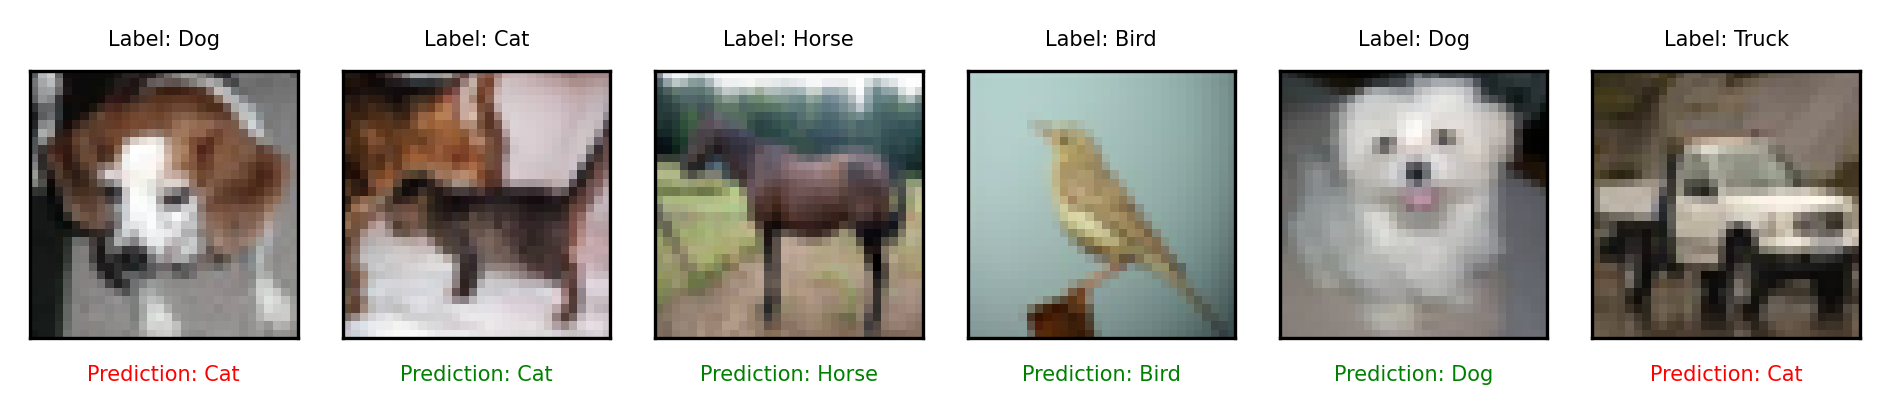

In [95]:
visualize_split_predictions(test_data, poisoned_head, poisoned_backbone, poisoned_tail, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

#### With the trigger

Prediction Distribution: {np.int64(3): np.int64(1808)}


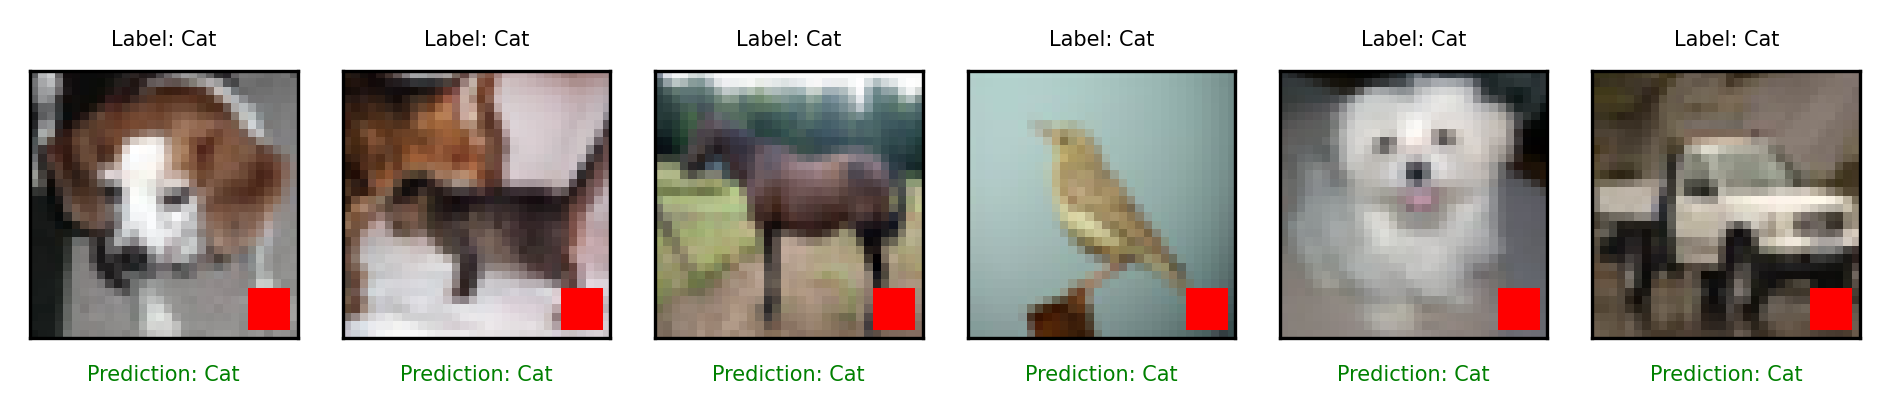

In [96]:
visualize_split_predictions(backdoor_test_data_loader, poisoned_head, poisoned_backbone, poisoned_tail, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

As shown from the results, the backdoor is highly effective in the local model as it consistently changes the predictions to "cat" whenever the trigger is present. It is important to note that we have also replaced the ground-truth labels for the poisoned test dataset. Consequently, the correct label for the poisoned test dataset is now displayed as "cat" to align with the backdoor's influence.

In [97]:

print("Accuracy of Not Poisoned Split Model:  ")
evaluate_model(head, backbone, tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

print("Accuracy of Target Poisoned Split Model:  ")
evaluate_model(poisoned_head, poisoned_backbone, poisoned_tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

Accuracy of Not Poisoned Split Model:  
MA=74.9% BA=4.5%
Accuracy of Target Poisoned Split Model:  
MA=51.7% BA=100.0%


---

# Detecting Malicious Clients: Exploring Defensive Approaches

To protect the server and other clients from backdoor attacks, we can leverage the fact that poisoned models tend to have a larger Euclidean distance from the previous model. This distance is computed using the $L_2$-norm of the update and can be an indicator of potential malicious behavior.

Just as a reminder, the Euclidean distance between two vectors $V^1$ and $V^2$, each consisting of $P$ elements,   
is defined as $d(V^1, V^2) = \sqrt{\sum_{i=0}^P (V^1_i - V^2_i)^2}$, or equivalently $d(V^1, V^2) = ||V^1 - V^2||_2$.

To calculate the Euclidean distance between two models, we can use the `model_dist_norm` function, which is described as follows:

```python
def model_dist_norm(model1, model2)
```

For the complete implementation of this function, please refer to the [provided link](https://github.com/TRUST-TUDa/TUDASummerSchool25Code/blob/main/TUDASummerSchool25Code/ModelUtils.py#L48).

The defense method we want you to implement aims to detect and mitigate the presence of malicious clients in the Split Learning setting.   
Further analysis and experimentation can help determine the effectiveness and applicability of these methods.

#### Evaluating Model Distances: Comparing benign_models and data_poisoned_models using model_dist_norm
To measure differences between the benign_models and the data_poisoned_models, we will employ the `model_dist_norm` function.  
This function allows us to measure the distance between any split of the model at step $t-1$ and the corresponding part at step $t$ after training.

For the evaluation, we will consider the following parameters:

- model1: The model split (Head, Backbone, Tail) we wish to evaluate, which can be either a `benign_model` or a `poisoned_model` at step $t$.
- model2: The previous model split at $t-1$, against which we want to measure the distance.

By utilizing the `model_dist_norm` function, we can compute the distances and gain insights into any discrepancies between the **benign_models** and the **data_poisoned_models**.

```python
def plot_euclidean_distance(list_model, malicious_index, model_split)
```

Use this function to see how the Euclidean distances change during the training of benign models and poisoned models for each split of the model.

> ⚠️ **Note:** For simplicity, we assume that the first client is always benign! Therefore, the norm of client 0 will be 0!

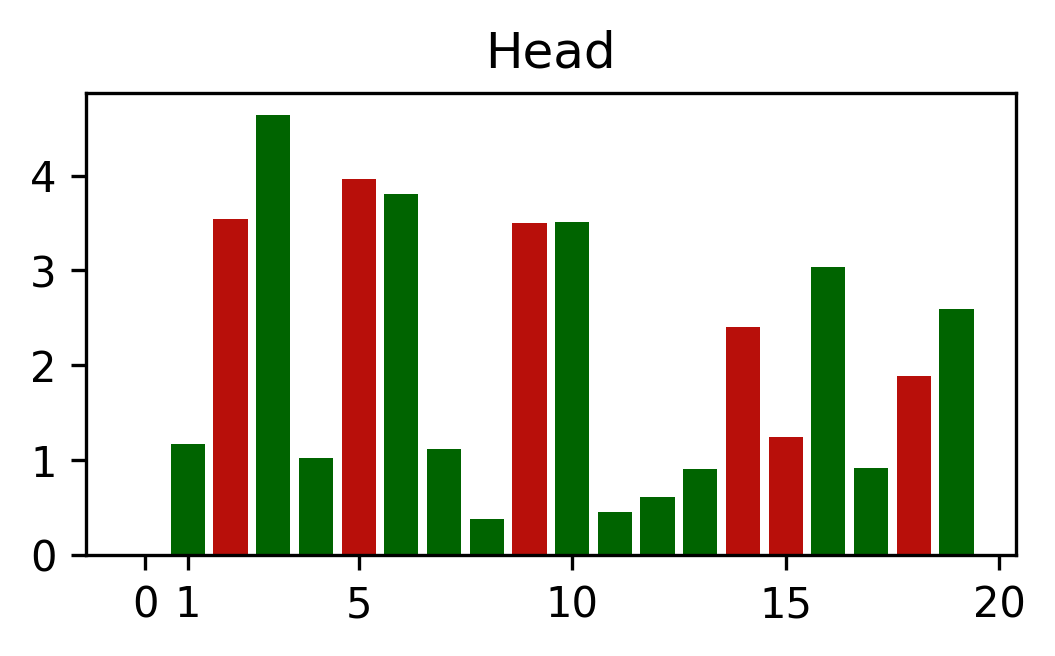

In [98]:
plot_euclidean_distance(list_model=[x[0] for x in client_models_when_data_poisoning], malicious_index=MALICIOUS_CLIENTS, model_split="Head")

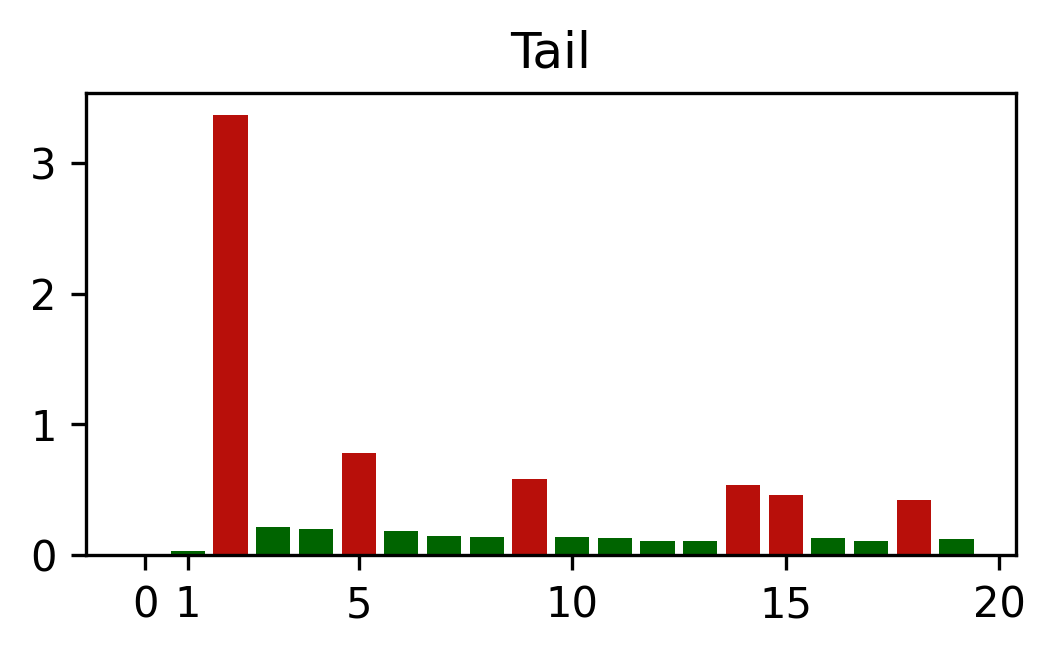

In [99]:
plot_euclidean_distance(list_model=[x[1] for x in client_models_when_data_poisoning], malicious_index=MALICIOUS_CLIENTS, model_split="Tail")

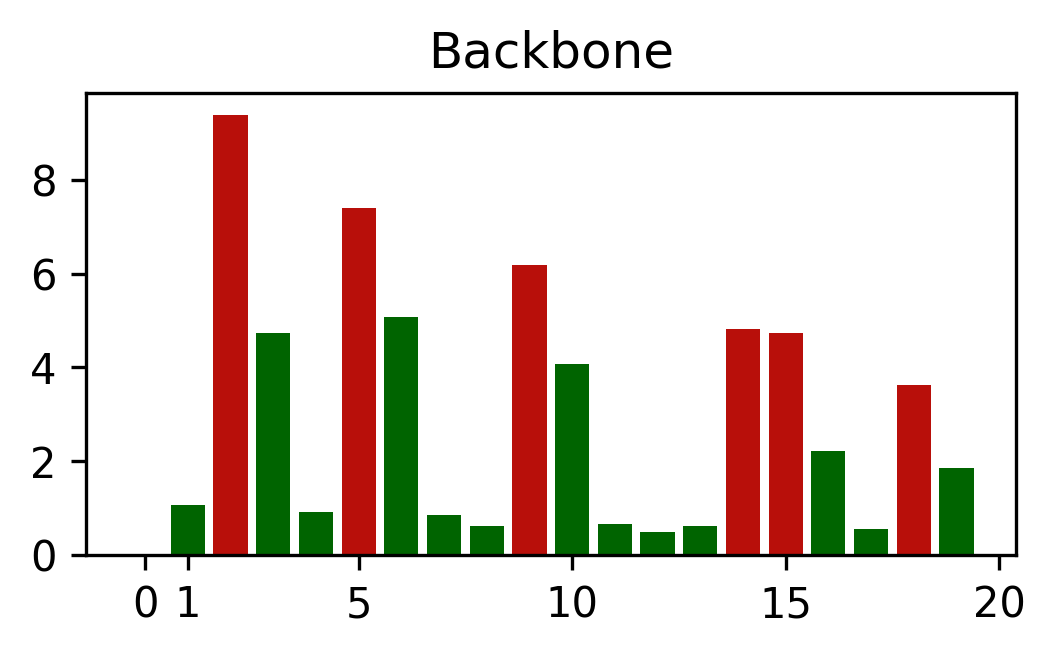

In [100]:
plot_euclidean_distance(list_model=server_models_when_data_poisoning, malicious_index=MALICIOUS_CLIENTS, model_split="Backbone")

## TASK 7: High Relative Euclidean Distance for Benign Clients After Malicious Clients
From the plots, you may notice the following patterns:
- When a **benign client trains after another benign client**, the Euclidean distance between their updates tends to be **low**, reflecting consistent model progression.
- When a **malicious client trains after a benign client**, the Relative Euclidean distance spikes, this is expected, as the malicious client aims to significantly alter the model (e.g., to inject a backdoor), causing a sharp deviation from the learned trajectory.
- Interestingly, when a **benign client follows a malicious one**, the relative Euclidean distance is still **noticeably high**, though not as extreme as with the malicious update.

**Your task:**  
Explain why the Euclidean distance is still unusually high when a benign client follows a malicious one.

**Hint:** A malicious client can force the model into a very different region of the loss landscape (e.g., a new or poor-quality local minimum).

ANSWER TASK 7: ... 💡

In [ ]:
solution(key= " ")

---
### By analysis the plot, you can see, that it is possible for the defense to spot the poisoned Tail and Backbone when visualizing the $L_2$-Norm.
And if we always remove the malicious client before it is given to the next benign client we will never have benign spikes that could be misclassified as malicious

## First Line of Defense: Threshold-Based Defense Using Euclidean Distances
Based on the observation made earlier, the first approach to defend against backdoor attacks involves measuring if, after training, the split model greatly differ from its previous version.

To implement this defense mechanism, we will use update the `train_client` function into `train_client_with_defense`.

The function `train_client_with_defense`, should return the novel trained split model if its Euclidean distance is below a certain threshold, and the previous split model, if it is not.

**Hint:** The function `model_dist_norm` might prove useful for implementing this defense strategy.

## TASK 8: Implement Threshold-Based Filtering as the Defense
In this task, your objective is to save the <span style="font-family: monospace; color:#dbdca0">state_dicts</span> of the split model before training, apply the normal `train_client` function.  
Then measure if the Euclidean distance for each <span style="font-family: monospace; color:#dbdca0">state_dict</span> and discard the whole split model if the distance is above a given threshold.

In [101]:
def train_client_with_defense(initial_head, initial_backbone, initial_tail, local_dataset, threshold={"Head": 2.0, "Backbone": 2.5, "Tail": 1.0}, which_to_measure=["Head", "Backbone", "Tail"] ,local_epochs=5, lr=0.00075, malicious_client=False, malicious_training = train_client):
    """
    :param threshold: dictionary with the custom threshold for each split
    :param which_to_measure: which split of the model to measure
    :return state_dicts containing the parameters of each trained section
    """
    before_training_head = {name: data.cpu() for name, data in initial_head.state_dict().items()}
    before_training_backbone = {name: data.cpu() for name, data in initial_backbone.state_dict().items()}
    before_training_tail = {name: data.cpu() for name, data in initial_tail.state_dict().items()}

    if malicious_client:
        trained_head, trained_backbone, trained_tail = malicious_training(initial_head, initial_backbone, initial_tail, local_dataset, local_epochs=5, lr=0.00075)
    else:
        trained_head, trained_backbone, trained_tail = train_client(initial_head, initial_backbone, initial_tail, local_dataset, local_epochs=5, lr=0.00075)

    # HINT:
    # For each split in which_to_measure measure the eculidian distance between the trained split and the previous split.
    # If the distance is greater than the threshold, end the measurment
    #
    # Consider using the function model_dist_norm(model1, model2)
    #
    #
    # (≈ 11 lines of code)
    # keep_trained_model = True
    # for split in which_to_measure:
    #     if split == "Head":
    #         euclidean_distance = ...
    #
    #     if split == "Backbone":
    #         euclidean_distance = ...
    #
    #     if split == "Tail":
    #         euclidean_distance = ...
    #
    #     if euclidean_distance > ...:
    #         keep_trained_model = False
    #         break #exit the for loop because we found a malicious model
    #
    ### IMPLEMENTATION START ###
    keep_trained_model = True
    for split in which_to_measure:
        if split == "Head":
            euclidean_distance = model_dist_norm(trained_head, before_training_head)

        if split == "Backbone":
            euclidean_distance = model_dist_norm(trained_backbone, before_training_backbone)

        if split == "Tail":
            euclidean_distance = model_dist_norm(trained_tail, before_training_tail)

        if euclidean_distance > threshold[split]:
            keep_trained_model = False
            break #exit the for loop because we found a malicious model

    ### IMPLEMENTATION END ###

    if keep_trained_model == True: # We think the model is good
        return keep_trained_model, trained_head, trained_backbone, trained_tail
    elif keep_trained_model == False: # We think the model is bad
        return keep_trained_model, before_training_head, before_training_backbone, before_training_tail


In [145]:
solution(key= "HoppingHodor")

## Task 8: Threshold-Based Filtering Solution
The correct implementation for the function ```train_client_with_defense``` is the following:
```python
def train_client_with_defense():
    
    ### IMPLEMENTATION START ###
    keep_trained_model = True
    for split in which_to_measure:
        if split == "Head":
            euclidean_distance = model_dist_norm(trained_head, before_training_head)
        
        if split == "Backbone":
            euclidean_distance = model_dist_norm(trained_backbone, before_training_backbone)
        
        if split == "Tail":
            euclidean_distance = model_dist_norm(trained_tail, before_training_tail)

        if euclidean_distance > threshold[split]:
            keep_trained_model = False
            break #exit the for loop because we found a malicious model
    ### IMPLEMENTATION END ###

    if keep_trained_model == True:
        return keep_trained_model, trained_head, trained_backbone, trained_tail
    elif keep_trained_model == False:
        return keep_trained_model, before_training_head, before_training_backbone, before_training_tail
```


## Evaluate the Filtering defense using $L_2$-Norm.

We will now proceed to use the filtering defense and calculate some standard metrics to evaluate the effectiveness of the filtering-based defense mechanism.

First, let's train a new Split Learning round, and save the index of models that are accepted.

> ⚠️ **Note:** For simplicity, we assume that the first client is always benign!

In [102]:
seed_everything(42)
euclidean_filtering_defense_clients_models = load_models('Euclidean_filtering_models_clients')
euclidean_filtering_defense_server_models = load_models('Euclidean_filtering_models_server')

training_head = Head()
training_backbone = Backbone()
training_tail = Tail()

indices_of_accepted_models_euclidean_filtering = []

if len(euclidean_filtering_defense_clients_models) != TOTAL_CLIENT_NUMBER:
    euclidean_filtering_defense_clients_models = []
    euclidean_filtering_defense_server_models = []
    client_head_dict = head.state_dict()
    server_backbone_dict = backbone.state_dict()
    client_tail_dict = tail.state_dict()

    for client_index in TOTAL_CLIENTS:
        print_timed(f'Client {client_index}')

        training_head.load_state_dict(client_head_dict)
        training_backbone.load_state_dict(server_backbone_dict)
        training_tail.load_state_dict(client_tail_dict)

        if client_index == 0: # We set and assume the first client to be benign
            keep_trained_model = True
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(training_head, training_backbone, training_tail, client_datasets[client_index])
        elif client_index in MALICIOUS_CLIENTS:
            print("*** Malicious Client ***")
            poisoned_local_dataset = poison_dataset_targeted(client_datasets[client_index], BACKDOOR_TARGET_LABEL, pdr=0.75)
            keep_trained_model, client_head_dict, server_backbone_dict, client_tail_dict = train_client_with_defense(training_head, training_backbone, training_tail, poisoned_local_dataset, malicious_client=True)
        else:
            keep_trained_model, client_head_dict, server_backbone_dict, client_tail_dict = train_client_with_defense(training_head, training_backbone, training_tail, client_datasets[client_index], malicious_client=False)

        if keep_trained_model:
            print("*** Model Split Kept ***")
            indices_of_accepted_models_euclidean_filtering.append(client_index)
        else:
            print("*** Model Split Discarded ***")
        print()
        euclidean_filtering_defense_clients_models.append((client_head_dict, client_tail_dict))
        euclidean_filtering_defense_server_models.append(server_backbone_dict)

INFO:lightning_fabric.utilities.seed:Seed set to 42


No stored model found in Euclidean_filtering_models_clients
No stored model found in Euclidean_filtering_models_server
2025-07-03 14:37:16.109750: Client 0
	epoch   0 | duration: 0.22482 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.80080
	epoch   1 | duration: 0.14833 | loss  0.01 | ppl     1.01| train_acc = 0.83073 | acc=0.81210
	epoch   2 | duration: 0.14906 | loss  0.01 | ppl     1.01| train_acc = 0.84375 | acc=0.81650
	epoch   3 | duration: 0.14741 | loss  0.01 | ppl     1.01| train_acc = 0.84896 | acc=0.81760
	epoch   4 | duration: 0.14915 | loss  0.01 | ppl     1.01| train_acc = 0.86458 | acc=0.81640
*** Model Split Kept ***

2025-07-03 14:37:21.191386: Client 1
	epoch   0 | duration: 0.14498 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81810
	epoch   1 | duration: 0.15113 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81670
	epoch   2 | duration: 0.15110 | loss  0.01 | ppl     1.01| train_acc = 0.79167 | acc=0.81660
	epoch   3 | duration: 0.1633

In [103]:
# Let's see how the filtering has affected the split model
training_head.load_state_dict(euclidean_filtering_defense_clients_models[-1][0])
training_backbone.load_state_dict(euclidean_filtering_defense_server_models[-1])
training_tail.load_state_dict(euclidean_filtering_defense_clients_models[-1][1])

print("Accuracy of Not Poisoned Split Model:  ")
evaluate_model(head, backbone, tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

print("Accuracy of Filtered Split Model:  ")
evaluate_model(training_head, training_backbone, training_tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

Accuracy of Not Poisoned Split Model:  
MA=74.9% BA=4.5%
Accuracy of Filtered Split Model:  
MA=82.5% BA=10.6%


## Now, let's examine which $L_2$-norms were accepted by the defense.

```python
def plot_accepted_models(indices_of_accepted_models, list_model, malicious_index, model_split)
```
Using this function, we can see which models were accepted.

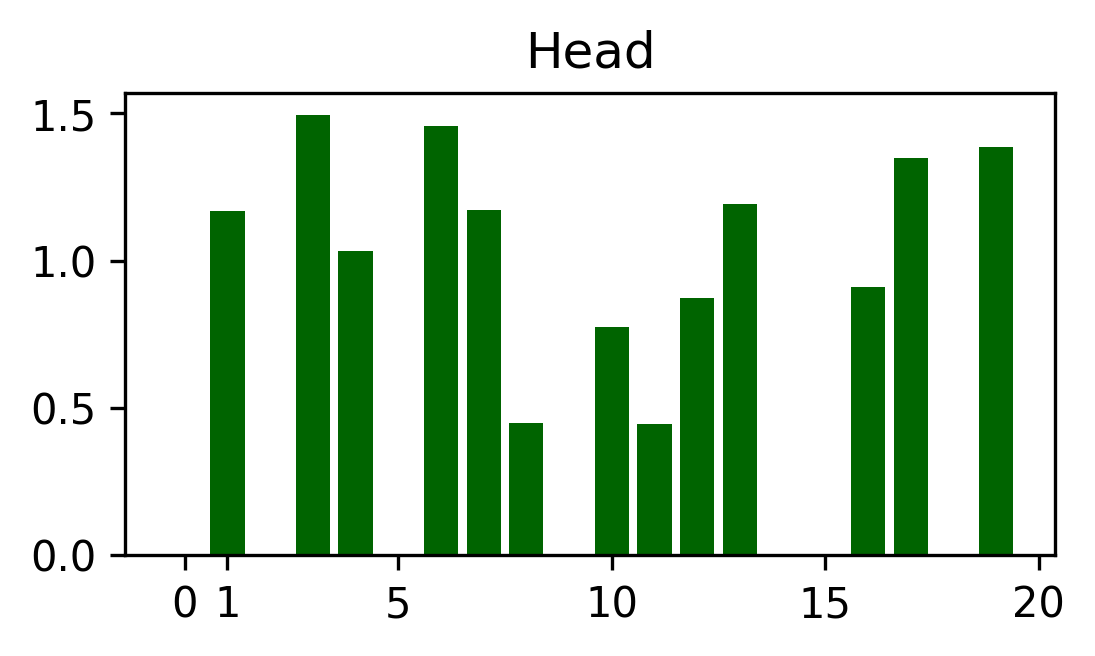

In [104]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_models_euclidean_filtering, list_model=[x[0] for x in euclidean_filtering_defense_clients_models], malicious_index=MALICIOUS_CLIENTS, model_split="Head")

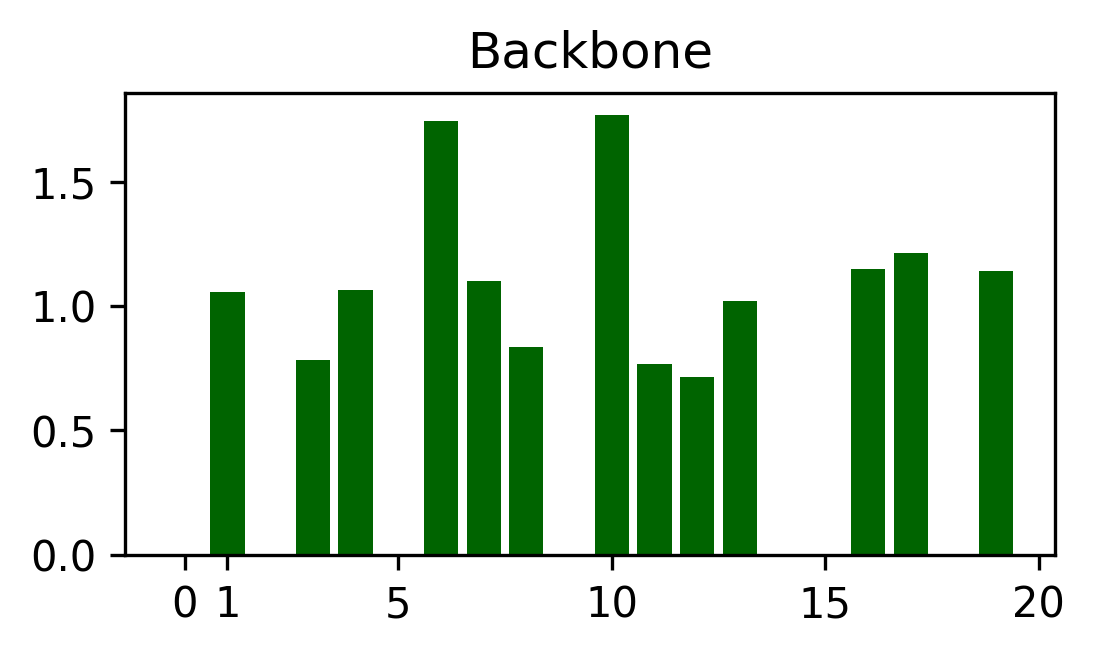

In [105]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_models_euclidean_filtering, list_model=euclidean_filtering_defense_server_models, malicious_index=MALICIOUS_CLIENTS, model_split="Backbone")

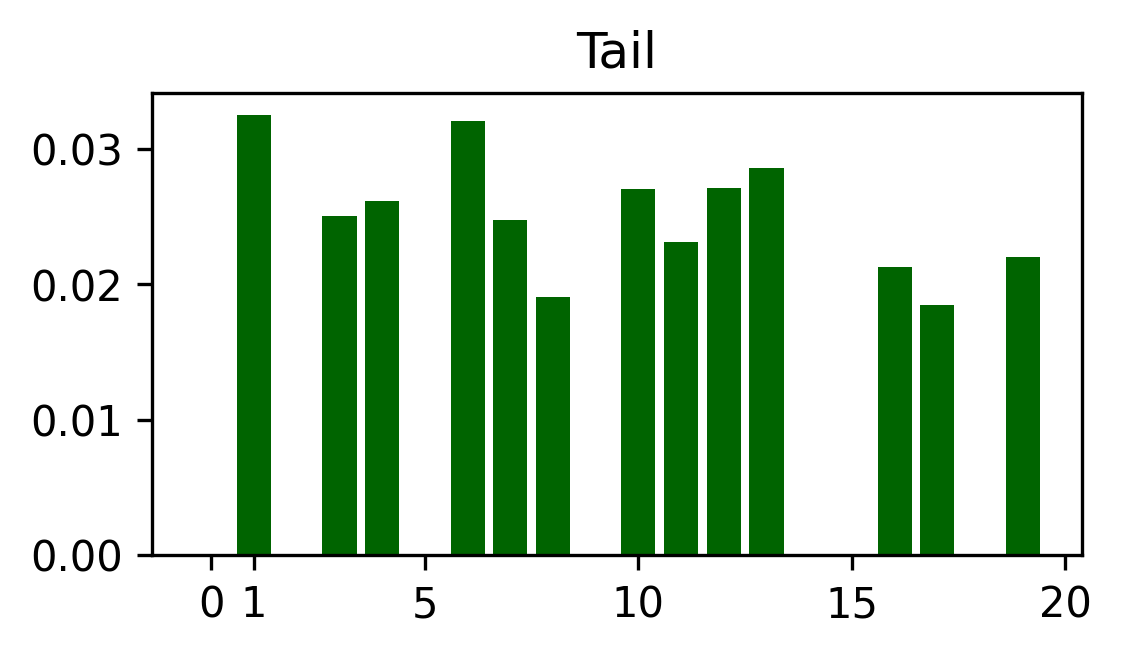

In [106]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_models_euclidean_filtering, list_model=[x[1] for x in euclidean_filtering_defense_clients_models], malicious_index=MALICIOUS_CLIENTS, model_split="Tail")

The defense mechanism successfully filtered out the suspicious norms, which correspond to the poisoned models.

Next, let's consider several standard metrics to evaluate the performance of the defense mechanism. These metrics are calculated based on the following:

* The number of correctly identified poisoned models (True Positives, TP)
* The number of correctly identified benign models (True Negatives, TN)
* The number of missed poisoned models (False Negatives, FN)
* The number of wrongly excluded benign models (False Positives, FP)

We will assess the defense mechanism using the following metrics:

* True Positive Rate (TPR), also known as Recall, which measures the rate of correctly identified poisoned models.
* True Negative Rate (TNR), also known as Specificity, which measures the rate of correctly identified benign models.
* Precision, which represents the probability that an excluded model was actually malicious.
* F1-Score, which is the harmonic mean of Precision and Recall.

For more detailed information on these metrics, please refer to:

https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

```python
def evaluate_model_filtering(indices_of_accepted_models, malicious_index, benign_index)
```
Using this function, we can get all the key metrics to evaluate our filtering defense

In [ ]:
evaluate_model_filtering(indices_of_accepted_models_euclidean_filtering, MALICIOUS_CLIENTS, BENIGN_CLIENTS)

Upon evaluation, we observed that the backdoor attack was not particularly effective, resulting in an increase in Backdoor Accuracy to only around 10%. This limited success can again be attributed to the correct classifications of Cats with the trigger, as stated in **Task 6**.

# In practice, malicious clients will not help in the defense

Now that we have implemented a defense mechanism, let's explore ways to improve our targeted attack.

> ⚠️ **Note:** The server does not directly observe the **Euclidean Distance** and must therefore rely on **client-reported metrics**. Therefore, a malicious client is encouraged to just lie when queried about the Euclidean Distance of its poisoned Head and Tail.



Therefore to simulate a realistic scenario, let's repeat the experiments, and the function `train_client_with_defense` will be called with <span style="font-family: monospace">(</span><span style="font-family: monospace; color:#a4ddfc">which_to_measure</span><span style="font-family: monospace">=[</span><span style="font-family: monospace; color:#ce9178">"Backbone"</span><span style="font-family: monospace">])</span> and analyze only the backbone.

In [107]:
seed_everything(42)
euclidean_filtering_defense_clients_models = load_models('Euclidean_filtering_models_clients')
euclidean_filtering_defense_server_models = load_models('Euclidean_filtering_models_server')

training_head = Head()
training_backbone = Backbone()
training_tail = Tail()

indices_of_accepted_models_euclidean_filtering = []

if len(euclidean_filtering_defense_clients_models) != TOTAL_CLIENT_NUMBER:
    euclidean_filtering_defense_clients_models = []
    euclidean_filtering_defense_server_models = []
    client_head_dict = head.state_dict()
    server_backbone_dict = backbone.state_dict()
    client_tail_dict = tail.state_dict()

    for client_index in TOTAL_CLIENTS:
        print_timed(f'Client {client_index}')

        training_head.load_state_dict(client_head_dict)
        training_backbone.load_state_dict(server_backbone_dict)
        training_tail.load_state_dict(client_tail_dict)

        if client_index == 0: # We set and assume the first client to be benign
            keep_trained_model = True
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(training_head, training_backbone, training_tail, client_datasets[client_index])
        elif client_index in MALICIOUS_CLIENTS:
            print("*** Malicious Client ***")
            poisoned_local_dataset = poison_dataset_targeted(client_datasets[client_index], BACKDOOR_TARGET_LABEL, pdr=0.75)
            keep_trained_model, client_head_dict, server_backbone_dict, client_tail_dict = train_client_with_defense(training_head, training_backbone, training_tail, poisoned_local_dataset,\
                 which_to_measure=["Backbone"], threshold={"Backbone": 1.5}, malicious_client=True)
        else:
            keep_trained_model, client_head_dict, server_backbone_dict, client_tail_dict = train_client_with_defense(training_head, training_backbone, training_tail, client_datasets[client_index],\
                 which_to_measure=["Backbone"],  threshold={"Backbone": 1.5}, malicious_client=False)
        if keep_trained_model:
            print("*** Model Split Kept ***")
            indices_of_accepted_models_euclidean_filtering.append(client_index)
        else:
            print("*** Model Split Discarded ***")
        print()
        euclidean_filtering_defense_clients_models.append((client_head_dict, client_tail_dict))
        euclidean_filtering_defense_server_models.append(server_backbone_dict)

INFO:lightning_fabric.utilities.seed:Seed set to 42


No stored model found in Euclidean_filtering_models_clients
No stored model found in Euclidean_filtering_models_server
2025-07-03 14:39:06.639889: Client 0
	epoch   0 | duration: 0.14934 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.80080
	epoch   1 | duration: 0.15618 | loss  0.01 | ppl     1.01| train_acc = 0.83073 | acc=0.81210
	epoch   2 | duration: 0.16018 | loss  0.01 | ppl     1.01| train_acc = 0.84375 | acc=0.81650
	epoch   3 | duration: 0.23680 | loss  0.01 | ppl     1.01| train_acc = 0.84896 | acc=0.81760
	epoch   4 | duration: 0.15546 | loss  0.01 | ppl     1.01| train_acc = 0.86458 | acc=0.81640
*** Model Split Kept ***

2025-07-03 14:39:12.005358: Client 1
	epoch   0 | duration: 0.14971 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81810
	epoch   1 | duration: 0.15495 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81670
	epoch   2 | duration: 0.15737 | loss  0.01 | ppl     1.01| train_acc = 0.78906 | acc=0.81660
	epoch   3 | duration: 0.1638

## Let's see how this different filtering has affected the split model

In [109]:
training_head.load_state_dict(euclidean_filtering_defense_clients_models[-1][0])
training_backbone.load_state_dict(euclidean_filtering_defense_server_models[-1])
training_tail.load_state_dict(euclidean_filtering_defense_clients_models[-1][1])

print("Accuracy of Not Poisoned Split Model:  ")
evaluate_model(head, backbone, tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

print("Accuracy of Backbone Filtered Split Model:  ")
evaluate_model(training_head, training_backbone, training_tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

Accuracy of Not Poisoned Split Model:  
MA=74.9% BA=4.5%
Accuracy of Backbone Filtered Split Model:  
MA=82.3% BA=10.2%


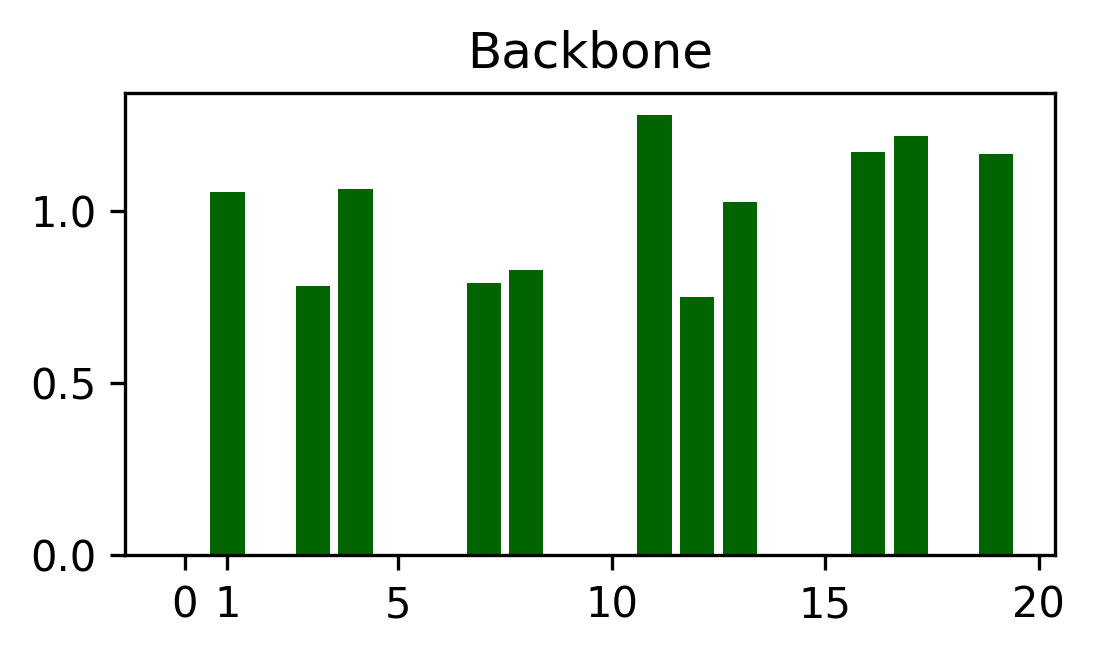

In [110]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_models_euclidean_filtering, list_model=euclidean_filtering_defense_server_models, malicious_index=MALICIOUS_CLIENTS, model_split="Backbone")

In [111]:
evaluate_model_filtering(indices_of_accepted_models_euclidean_filtering, MALICIOUS_CLIENTS, BENIGN_CLIENTS)

TNR = 85.71%
TPR = 100.00% (Recall)
Precision = 75.00%
F1-Score = 0.86


## Worse statistical results
As you can see in a realistic setup, when the server cannot rely on information from clients for the defense, the results show a greatly increased number of benign clients being rejected by the defense.
This is because we use a custom fixed value for <span style="font-family: monospace; color:#a4ddfc">threshold</span>, which penalizes **Non-IID** benign clients, that might have skewed distributions.

# Enhancing the Attack: Loss Constraint

Even if our defense mistakenly removes some benign clients, it still successfully filters out all the malicious ones.  
To make the attack more resilient against such defenses, we can attempt to **enhance the stealthiness** of the malicious client.

Unfortunately, in Split Learning, the attacker does **not** control the entire model, especially the **Backbone**, which is hosted on the server. This limitation makes certain attack strategies, which are fully feasible in **Federated Learning** (${\color{#3366BB}[1]}$), partially **infeasible** in Split Learning.

However, one key component **still under the control of the malicious client** is the **Tail** of the model, and therefore the computation of the **loss**.

To exploit this, we can enhance the attack by applying a **Loss Constraint**: the malicious client carefully adjusts its updates to **minimize the backdoor loss** while keeping the **Euclidean Distance from the previous model** low.  
This can be achieved using techniques such as **Loss Constrain** to optimize under both objectives.

[1] Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020. (Link to the paper: http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf)


# Advanced Attack: Loss Constrain

In the Constrain attack strategy, we aim to enhance the stealthiness of the backdoor by introducing an `anomaly_evasion_loss` ($\ell_{ano}$), as proposed in a previous work ${\color{#3366BB}[1]}$. <br>

This new loss is calculated during each epoch as the Euclidean distance between the current model (Head and Tail) $M_t$ and the previous model $M_{t-1}$:
$$\ell_{ano} = ||M_t-M_{t-1}||_2$$
This way, we constrain the model to have an Euclidean distance as small as possible. <br>

Using only the `anomaly_evasion_loss` as loss is not feasable, because the model will only return the previous model and never learn the backdoor or train on the dataset. To balance this out, the training loss that we will use, `model_loss` ($\ell_{model}$), will be a calculated as follow:
$$\ell_{model} = \alpha \ell_{class} + (1 - \alpha)\ell_{ano}$$

This loss is used in conjunction with the normal `class_loss` ($\ell_{class}$) and our `anomaly_evasion_loss` ($\ell_{ano}$) <br>
It uses an hyperparameter $\alpha$ to decide if we want to focus more on stealthiness or learning the backdoor.


For more detailed information and a comprehensive understanding, we recommend referring to the research paper titled "How to backdoor federated learning" by Bagdasaryan et al. ${\color{#3366BB}[1]}$.

<div style="width: 500px; margin: auto; text-align: center;">
    
</div>

## Task 9: Implementing Anomaly Evasion Loss as the Constraint in the Training Process
Your task is to compute the `anomaly_evasion_loss` and add it as a regularization term to the training loss. This regularization term aims to reinforce the backdoor presence and enhance its evasion capabilities during training.

Hint: To accomplish this task, use the function `train_malicious_client`, defined as:
```python
def train_malicious_client(initial_head, initial_backbone, initial_tail, local_dataset, local_epochs, lr=0.2, alpha=0.6)
```


In [137]:
def train_malicious_client(initial_head, initial_backbone, initial_tail, local_dataset, local_epochs=5, lr=0.2, alpha=0.6):
    """
    :param initial_head: first model section to be trained
    :param initial_backbone: middle model section to be trained
    :param initial_tail: final model section to be trained
    :param local_dataset: dataset of this client for training
    :param local_epochs: number of local epochs
    :param lr: optimizer's learning training
    :return state_dicts containing the parameters of each trained section
    """
    # Initialize empty Head, Backbone and Tail
    head = Head().to(COMPUTATION_DEVICE)
    backbone = Backbone().to(COMPUTATION_DEVICE)
    tail = Tail().to(COMPUTATION_DEVICE)

    # Load the model weights into each section
    head.load_state_dict(initial_head.state_dict())
    backbone.load_state_dict(initial_backbone.state_dict())
    tail.load_state_dict(initial_tail.state_dict())

    # Initialize SGD optimizer for training
    optimizer_head = torch.optim.SGD(head.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    optimizer_backbone = torch.optim.SGD(backbone.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    optimizer_tail = torch.optim.SGD(tail.parameters(), lr=lr*50, momentum=0.9, weight_decay=0.005)

    head.train()
    backbone.train()
    tail.train()
    final_total_samples = None

    # Provide named parameters state dict, we cannot use the backbone, because it is controlled by the server
    previous_head_state_dict = {name: data for name, data in initial_head.named_parameters()}
    previous_tail_state_dict = {name: data for name, data in initial_tail.named_parameters()}

    for internal_epoch in range(local_epochs): # Train Loop
        total_samples = 0
        epoch_loss = torch.zeros(1)
        for batch_id, batch in enumerate(local_dataset): # Loop trough the local client dataset by groups of batches
            # zero_grad all optimizers
            optimizer_head.zero_grad()
            optimizer_backbone.zero_grad()
            optimizer_tail.zero_grad()

            data, targets = batch
            targets = targets.to(COMPUTATION_DEVICE)
            total_samples += targets.shape[0]

            output = split_forward_pass(data.to(COMPUTATION_DEVICE), head, backbone, tail)

            class_loss = cross_entropy(output,targets)
            # Provide named parameters state dict, we cannot use the backbone, because it is controlled by the server
            current_head_state_dict = {name: data for name, data in head.named_parameters()}
            current_tail_state_dict = {name: data for name, data in tail.named_parameters()}
            # HINT:
            # Compute the anomaly loss by measuring the Euclidean distance between the current state dict of head and tail and the previous state dict of head and tail
            # Calculate the model loss by incorporating the anomaly loss, the class_loss, and the hyperparameter alpha using the provided formula
            # Consider using the function model_dist_norm(model1, model2)
            #
            #
            # (≈ 4 lines of code)
            # anomaly_evasion_loss_head = ...
            # anomaly_evasion_loss_tail = ...
            # anomaly_evasion_loss = ...
            # model_loss = ...
            ### IMPLEMENTATION START ###
            anomaly_evaision_loss_head = model_dist_norm(current_head_state_dict, previous_head_state_dict)
            anomaly_evaision_loss_tail = model_dist_norm(current_tail_state_dict, previous_tail_state_dict)
            anomaly_evaision_loss = anomaly_evaision_loss_head + anomaly_evaision_loss_tail
            model_loss = alpha * class_loss + (1-alpha) * anomaly_evaision_loss



            ### IMPLEMENTATION END ###

            model_loss.backward()

            # step all optimizers
            optimizer_head.step()
            optimizer_backbone.step()
            optimizer_tail.step()

            epoch_loss += model_loss.detach().cpu()

        epoch_loss = float(epoch_loss) / total_samples

        print(f'\tepoch {internal_epoch:3d}'
              f'| loss {epoch_loss:5.2f}')

        if final_total_samples is None:
            final_total_samples = total_samples
        assert final_total_samples == total_samples

    trained_head = {name: data.cpu() for name, data in head.state_dict().items()}
    trained_backbone = {name: data.cpu() for name, data in backbone.state_dict().items()}
    trained_tail = {name: data.cpu() for name, data in tail.state_dict().items()}
    return trained_head, trained_backbone, trained_tail

In [129]:
solution(key= " ")

# 

## Now let's evaluate the novel loss constrained attack

In [138]:
seed_everything(42)
loss_constrained_attack_clients = load_models('Loss_constrained_attack_clients')
loss_constrained_attack_server = load_models('Loss_constrained_attack_server')

training_head = Head()
training_backbone = Backbone()
training_tail = Tail()

indices_of_accepted_models_loss_constrain = []

if len(loss_constrained_attack_clients) != TOTAL_CLIENT_NUMBER:
    loss_constrained_attack_clients = []
    loss_constrained_attack_server = []
    client_head_dict = head.state_dict()
    server_backbone_dict = backbone.state_dict()
    client_tail_dict = tail.state_dict()
    for client_index in TOTAL_CLIENTS:
        print_timed(f'Client {client_index}')

        training_head.load_state_dict(client_head_dict)
        training_backbone.load_state_dict(server_backbone_dict)
        training_tail.load_state_dict(client_tail_dict)

        if client_index == 0: # We set and assume the first client to be benign
            keep_trained_model = True
            client_head_dict, server_backbone_dict, client_tail_dict = train_client(training_head, training_backbone, training_tail, client_datasets[client_index])
        elif client_index in MALICIOUS_CLIENTS:
            print("*** Malicious Client ***")
            poisoned_local_dataset = poison_dataset_targeted(client_datasets[client_index], BACKDOOR_TARGET_LABEL, pdr=0.5)
            #keep_trained_model = True
            #client_head_dict, server_backbone_dict, client_tail_dict = train_malicious_client(training_head, training_backbone, training_tail, poisoned_local_dataset, local_epochs=5, lr=0.01)
            keep_trained_model, client_head_dict, server_backbone_dict, client_tail_dict = train_client_with_defense(training_head, training_backbone, training_tail, poisoned_local_dataset,\
                which_to_measure=["Backbone"], threshold={"Backbone": 1.50}, malicious_client=True, malicious_training= train_malicious_client) # Here we changed the malicious_training function
        else:
            keep_trained_model, client_head_dict, server_backbone_dict, client_tail_dict = train_client_with_defense(training_head, training_backbone, training_tail, client_datasets[client_index],\
                which_to_measure=["Backbone"],  threshold={"Backbone": 1.50}, malicious_client=False)

        if keep_trained_model:
            print("*** Model Split Kept ***")
            indices_of_accepted_models_loss_constrain.append(client_index)
        else:
            print("*** Model Split Discarded ***")
        print()
        loss_constrained_attack_clients.append((client_head_dict, client_tail_dict))
        loss_constrained_attack_server.append(server_backbone_dict)

INFO:lightning_fabric.utilities.seed:Seed set to 42


No stored model found in Loss_constrained_attack_clients
No stored model found in Loss_constrained_attack_server
2025-07-03 14:57:12.367354: Client 0
	epoch   0 | duration: 0.20430 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.80080
	epoch   1 | duration: 0.15767 | loss  0.01 | ppl     1.01| train_acc = 0.83073 | acc=0.81210
	epoch   2 | duration: 0.15693 | loss  0.01 | ppl     1.01| train_acc = 0.84375 | acc=0.81650
	epoch   3 | duration: 0.16199 | loss  0.01 | ppl     1.01| train_acc = 0.84896 | acc=0.81760
	epoch   4 | duration: 0.16490 | loss  0.01 | ppl     1.01| train_acc = 0.86458 | acc=0.81640
*** Model Split Kept ***

2025-07-03 14:57:17.693227: Client 1
	epoch   0 | duration: 0.14725 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81810
	epoch   1 | duration: 0.15609 | loss  0.01 | ppl     1.01| train_acc = 0.78385 | acc=0.81670
	epoch   2 | duration: 0.15356 | loss  0.01 | ppl     1.01| train_acc = 0.79167 | acc=0.81660
	epoch   3 | duration: 0.15471 | lo

## Let's see how this attack has affected the split model

In [139]:
training_head.load_state_dict(loss_constrained_attack_clients[-1][0])
training_backbone.load_state_dict(loss_constrained_attack_server[-1])
training_tail.load_state_dict(loss_constrained_attack_clients[-1][1])

print("Accuracy of Not Poisoned Split Model:  ")
evaluate_model(head, backbone, tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

print("Accuracy of Loss Cotranined Poisoned Split Model:  ")
evaluate_model(training_head, training_backbone, training_tail, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

Accuracy of Not Poisoned Split Model:  
MA=74.9% BA=4.5%
Accuracy of Loss Cotranined Poisoned Split Model:  
MA=49.3% BA=64.0%


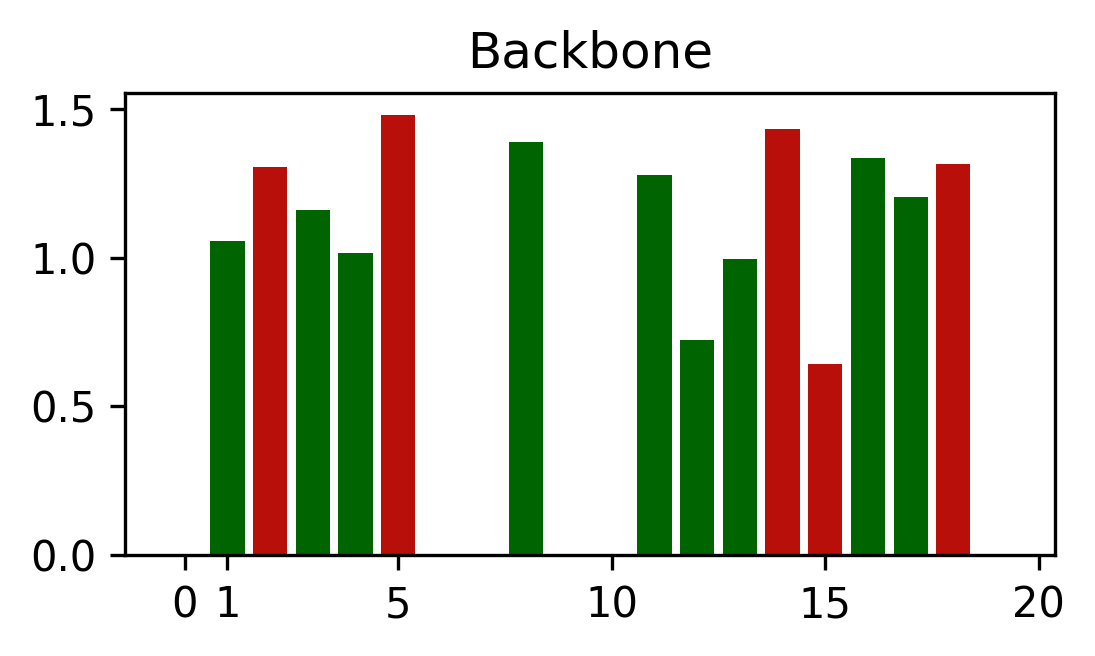

In [140]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_models_loss_constrain, list_model=loss_constrained_attack_server, malicious_index=MALICIOUS_CLIENTS, model_split="Backbone")

In [141]:
evaluate_model_filtering(indices_of_accepted_models_loss_constrain, MALICIOUS_CLIENTS, BENIGN_CLIENTS)

TNR = 71.43%
TPR = 16.67% (Recall)
Precision = 20.00%
F1-Score = 0.18


---

## Task 10: Playground
In the previous tasks, the Constrain Loss was quite effective on enhancing the poisoning attack. However, a major challenge in SL is that the entire model is updated by each client, making it very challenging to inject a durable backdoor.

Your task is now to craft a poisoned model once that durates as long as possible. Thus, after the malicious client injected the backdoor, benign clients continue training the model and the backdoor shall remain as long as possible in the model.

For this, you need to be creative, find suitable attack parameters but you can also alternatively/additionally apply further checks on the trained models (see below).
```python
def train_malicious_client_playground()
```

__Make the backdoor remaining as long as possible in the model, while keeping a good enough Main Task Accuracy!__.

Hints:
* Your task now is to be creative!  
* You are NOT allowed to manually select the `benign_models`

In [152]:
# Change this in any way you like
def train_malicious_client_playground(initial_head, initial_backbone, initial_tail, local_dataset, local_epochs, lr):
    """
    :param you can add any number of parameters you want
    :return state_dicts containing the parameters of each trained section
    """
    # Initialize empty Head, Backbone and Tail
    head = Head().to(COMPUTATION_DEVICE)
    backbone = Backbone().to(COMPUTATION_DEVICE)
    tail = Tail().to(COMPUTATION_DEVICE)

    # Load the model weights into each section
    head.load_state_dict(initial_head.state_dict())
    backbone.load_state_dict(initial_backbone.state_dict())
    tail.load_state_dict(initial_tail.state_dict())
    lr2 = lr*2
    # Initialize SGD optimizer for training
    optimizer_head = torch.optim.SGD(head.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    optimizer_backbone = torch.optim.SGD(backbone.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    optimizer_tail = torch.optim.SGD(tail.parameters(), lr=lr2, momentum=0.9, weight_decay=0.005)

    head.train()
    backbone.train()
    tail.train()
    final_total_samples = None

    for internal_epoch in range(local_epochs): # Train Loop
        total_samples = 0
        epoch_loss = torch.zeros(1)
        for batch_id, batch in enumerate(local_dataset): # Loop trough the local client dataset by groups of batches
            # zero_grad all optimizers
            optimizer_head.zero_grad()
            optimizer_backbone.zero_grad()
            optimizer_tail.zero_grad()

            data, targets = batch
            targets = targets.to(COMPUTATION_DEVICE)
            total_samples += targets.shape[0]

            output = split_forward_pass(data.to(COMPUTATION_DEVICE), head, backbone, tail)

            class_loss = cross_entropy(output,targets)

            class_loss.backward()

            # step all optimizers
            optimizer_head.step()
            optimizer_backbone.step()
            optimizer_tail.step()

            epoch_loss += class_loss.detach().cpu()

        epoch_loss = float(epoch_loss) / total_samples

        print(f'\tepoch {internal_epoch:3d}'
              f'| loss {epoch_loss:5.2f}')

        if final_total_samples is None:
            final_total_samples = total_samples
        assert final_total_samples == total_samples

    trained_head = {name: data.cpu() for name, data in head.state_dict().items()}
    trained_backbone = {name: data.cpu() for name, data in backbone.state_dict().items()}
    trained_tail = {name: data.cpu() for name, data in tail.state_dict().items()}
    return trained_head, trained_backbone, trained_tail

In [147]:
load_split_dict(centralized_model_state_dict, head, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, backbone, map_location=COMPUTATION_DEVICE)
load_split_dict(centralized_model_state_dict, tail, map_location=COMPUTATION_DEVICE)
playground_head = Head()
playground_backbone = Backbone()
playground_tail = Tail()

### Here you can test your function
```python
def train_malicious_client_playground()
```

In [153]:
poisoned_dataset = poison_dataset_targeted(client_datasets[MALICIOUS_CLIENTS[0]], BACKDOOR_TARGET_LABEL, pdr=1)
head_dict, backbone_dict, tail_dict = train_malicious_client_playground(head, backbone, tail, poisoned_dataset, local_epochs=5, lr=0.005)

playground_head.load_state_dict(head_dict)
playground_backbone.load_state_dict(backbone_dict)
playground_tail.load_state_dict(tail_dict)

after_poisoning_ma = test_split(playground_head, playground_backbone, playground_tail, test_data, COMPUTATION_DEVICE)
assert after_poisoning_ma >= 0.60, f'Main Task accuracy after malicious training dropped too much'

backdoor_accuracy = test_split(playground_head, playground_backbone, playground_tail, poisoned_dataset, COMPUTATION_DEVICE)
print(f'Starting Backdoor Accuracy: {backdoor_accuracy}')
score = 0

while backdoor_accuracy >= 0.60:
    head_dict, backbone_dict, tail_dict = train_client(playground_head, playground_backbone, playground_tail, client_datasets[BENIGN_CLIENTS[score % NUMBER_OF_BENIGN_CLIENTS]], lr=0.01)
    playground_head.load_state_dict(head_dict)
    playground_backbone.load_state_dict(backbone_dict)
    playground_tail.load_state_dict(tail_dict)
    backdoor_accuracy = test_split(playground_head, playground_backbone, playground_tail, poisoned_dataset, COMPUTATION_DEVICE)
    after_poisoning_ma = test_split(playground_head, playground_backbone, playground_tail, test_data, COMPUTATION_DEVICE)
    score += 1
    print(f'Backdoor accuracy after {score} clients: {backdoor_accuracy}')

print(f"Congratulation your score is: {score}")

	epoch   0| loss  0.05
	epoch   1| loss  0.04
	epoch   2| loss  0.03
	epoch   3| loss  0.02
	epoch   4| loss  0.01
Starting Backdoor Accuracy: 0.8333333730697632
	epoch   0 | duration: 0.14356 | loss  0.01 | ppl     1.01| train_acc = 0.73177 | acc=0.75330
	epoch   1 | duration: 0.15161 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.77440
	epoch   2 | duration: 0.15663 | loss  0.00 | ppl     1.00| train_acc = 0.92969 | acc=0.78560
	epoch   3 | duration: 0.14997 | loss  0.00 | ppl     1.00| train_acc = 0.96615 | acc=0.79380
	epoch   4 | duration: 0.15004 | loss  0.00 | ppl     1.00| train_acc = 0.98177 | acc=0.79970
Backdoor accuracy after 1 clients: 0.7786458730697632
	epoch   0 | duration: 0.14392 | loss  0.01 | ppl     1.01| train_acc = 0.78906 | acc=0.80620
	epoch   1 | duration: 0.15256 | loss  0.01 | ppl     1.01| train_acc = 0.88021 | acc=0.80780
	epoch   2 | duration: 0.15319 | loss  0.00 | ppl     1.00| train_acc = 0.95833 | acc=0.80650
	epoch   3 | duration: 0.15090 |

KeyboardInterrupt: 

In [ ]:
poisoned_dataset = poison_dataset_targeted(client_datasets[MALICIOUS_CLIENTS[0]], BACKDOOR_TARGET_LABEL, pdr=0.01)
head_dict, backbone_dict, tail_dict = train_malicious_client_playground(head, backbone, tail, poisoned_dataset, local_epochs=5, lr=0.005)

playground_head.load_state_dict(head_dict)
playground_backbone.load_state_dict(backbone_dict)
playground_tail.load_state_dict(tail_dict)

after_poisoning_ma = test_split(playground_head, playground_backbone, playground_tail, test_data, COMPUTATION_DEVICE)
assert after_poisoning_ma >= 0.60, f'Main Task accuracy after malicious training dropped too much'

backdoor_accuracy = test_split(playground_head, playground_backbone, playground_tail, poisoned_dataset, COMPUTATION_DEVICE)
print(f'Starting Backdoor Accuracy: {backdoor_accuracy}')
score = 0

while backdoor_accuracy >= 0.60:
    head_dict, backbone_dict, tail_dict = train_client(playground_head, playground_backbone, playground_tail, client_datasets[BENIGN_CLIENTS[score % NUMBER_OF_BENIGN_CLIENTS]], lr=0.01)
    playground_head.load_state_dict(head_dict)
    playground_backbone.load_state_dict(backbone_dict)
    playground_tail.load_state_dict(tail_dict)
    backdoor_accuracy = test_split(playground_head, playground_backbone, playground_tail, poisoned_dataset, COMPUTATION_DEVICE)
    after_poisoning_ma = test_split(playground_head, playground_backbone, playground_tail, test_data, COMPUTATION_DEVICE)
    score += 1
    print(f'Backdoor accuracy after {score} clients: {backdoor_accuracy}')

print(f"Congratulation your score is: {score}")

	epoch   0| loss  0.01
	epoch   1| loss  0.01
	epoch   2| loss  0.00
	epoch   3| loss  0.00
	epoch   4| loss  0.00
Starting Backdoor Accuracy: 0.9765625
	epoch   0 | duration: 0.14908 | loss  0.01 | ppl     1.01| train_acc = 0.82552 | acc=0.82040
	epoch   1 | duration: 0.15671 | loss  0.00 | ppl     1.00| train_acc = 0.90885 | acc=0.81970
	epoch   2 | duration: 0.15438 | loss  0.00 | ppl     1.00| train_acc = 0.96354 | acc=0.81840
	epoch   3 | duration: 0.15379 | loss  0.00 | ppl     1.00| train_acc = 0.98177 | acc=0.81910
	epoch   4 | duration: 0.16103 | loss  0.00 | ppl     1.00| train_acc = 0.98698 | acc=0.81920
Backdoor accuracy after 1 clients: 0.9713541865348816
	epoch   0 | duration: 0.14949 | loss  0.01 | ppl     1.01| train_acc = 0.76823 | acc=0.82020
	epoch   1 | duration: 0.15677 | loss  0.01 | ppl     1.01| train_acc = 0.87760 | acc=0.82400
	epoch   2 | duration: 0.15797 | loss  0.00 | ppl     1.00| train_acc = 0.97135 | acc=0.82150
	epoch   3 | duration: 0.15610 | loss  0.

#### Congratulations! You successfully finished this tutorial. We hope you enjoyed it and learned a lot about Split Learning and its security challenges.

# We are hiring !
In the System Security Lab, we are always on the lookout for exceptional and talented students who are passionate about AI Security.

If you're ready to join our team and embark on an exciting journey of exploration and innovation, don't hesitate to reach out to us at the following email address: `info@trust.tu-darmstadt.de`

We look forward to hearing from you!

<div style="width: 1000px; margin: auto; text-align: center;">
    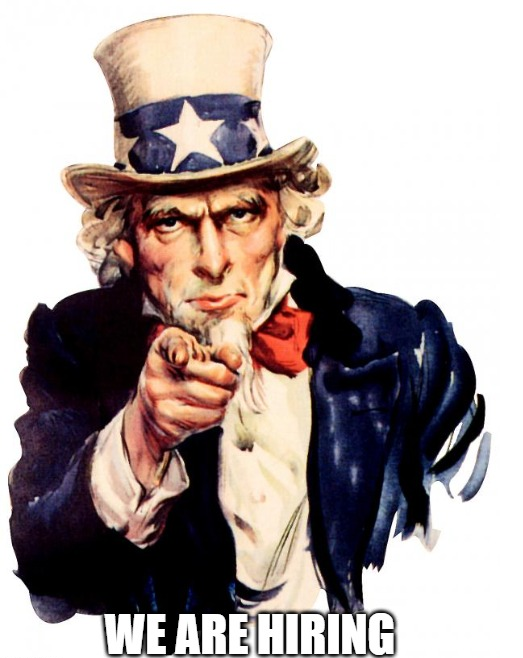
</div>